# Проект: "Определение стоимости автомобилей"

**Описание проекта:** 

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Цель проекта:** Построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Примечания к выполнению проекта:**
1. Для оценки качества моделей применяйте метрику RMSE.
2. Значение метрики RMSE должно быть меньше 2500.
3. Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
4. Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её (и используйте в работе).
5. Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

**Описание данных:**

Данные сервиса по продаже автомобилей с пробегом "Не бит, не крашен" находятся в файле: *'autos.csv'*.

В нем присутствуют следующие **признаки**:
- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л.с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя;

И **целевой признак**:
- Price — цена (евро).

**План работы с проектом:**
1. Загрузка и изучение данных;
2. Предобработка и исследовательский анализ данных;
3. Подготовка выборок для обучения моделей;
4. Обучение и предсказание моделей;
5. Анализ времени обучения, времени предсказания и качества моделей. Выбор лучшей модели;
6. Формирование итоговых выводов.

## 1. Загрузка и изучение данных

In [1]:
# установим, необходимую библиотеку
!pip install catboost

In [2]:
# установим необходимую библиотеку
!pip install lightgbm

In [3]:
# загрузим стандартные библиотеки, необходимые для работы
import pandas as pd
import math
import sklearn
import numpy as np
from scipy import stats as st

# загрузим библиотеки для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns

# загрузим модули, необходимые для работы
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from tqdm.notebook import tqdm
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

# загрузим новые библиотеки
from lightgbm import LGBMRegressor 
import time
import warnings
warnings.filterwarnings('ignore')

# зададим константу
RANDOM_STATE = 42

In [4]:
# загрузим данные из файла 'autos.csv'
try:
    # локальный путь к файлу
    data = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Численные_методы/autos.csv')
except:
    # путь к файлу в тренажере
    data = pd.read_csv('/datasets/autos.csv')

# посмотрим первые 5 строк датафрема
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# посмотрим общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Обобщающий вывод этапа "Загрузка и изучение данных":** 
1. Данные в таблице соответсвуют описанию задачи.
2. В таблице необходимо привести названия столбцов к общему стилю.
3. Присутствуют пропуски в 5 столбцах таблицы.
4. Не для всех столбцов указан корректный тип данных.

## 2. Предобработка и исследовательский анализ данных

In [6]:
# по результатам загрузки данных стало видно, что в таблице 'data' названия столбцов необходимо привести к общему стилю
# выведем все названия столбцов
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [7]:
# переименуем столбцы к общепринятому стилю
data.columns = data.columns.str.replace('(.)([A-Z])', r'\1_\2', regex=True).str.lower()

# выведем первые 5 строк таблицы с переименованными столбцами
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Примечание:** Исходные названия столбцов успешно приведены к общепринятому стилю.

In [8]:
# проверим датафрейм на наличие явных дубликатов
data.duplicated().sum()

4

In [9]:
# в таблице присутствует 4 явных дубликата, удалим их
data = data.drop_duplicates()

# проверим датафрейм на наличие явных дубликатов после удаления уже выявленных
data.duplicated().sum()

0

**Примечание:** Явные дубликаты успешно удалены из таблицы, теперь их количество равно нулю.

In [10]:
# по результатам загрузки данных стало видно, чтов таблице 'data' не во всех столбцах указан корректный тип данных
# снова посмотрим общую и нформацию о таблице 
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        316875 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             334532 non-null  object
 5   power               354365 non-null  int64 
 6   model               334660 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           321470 non-null  object
 10  brand               354365 non-null  object
 11  repaired            283211 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes: int6

**Примечание:** По общей информации о таблице видно, что нужно изменить тип данных в столбцах 'date_crawled', 'date_created', 'last_seen'.

In [12]:
# приведем данные в выделенных столбцах к нужному формату
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [13]:
# посмотрим общую информацию о всей таблице после изменений
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 non-nul

**Примечание:** Типы данных в столбцах 'date_crawled', 'date_created', 'last_seen' успешно изменены.

### 2.1 Предобработка и исследовательский анализ данных в столбце 'date_crawled'

In [14]:
# посмотрим описательную статистику признака 'date_crawled'
data['date_crawled'].describe().to_frame()

,date_crawled
count,354365
mean,2016-03-21 12:58:09.520460544
min,2016-03-05 14:06:22
25%,2016-03-13 11:52:33
50%,2016-03-21 17:50:55
75%,2016-03-29 14:37:20
max,2016-04-07 14:36:58


In [15]:
# посмотрим количество пропусков в столбце 'date_crawled'
data['date_crawled'].isna().sum()

0

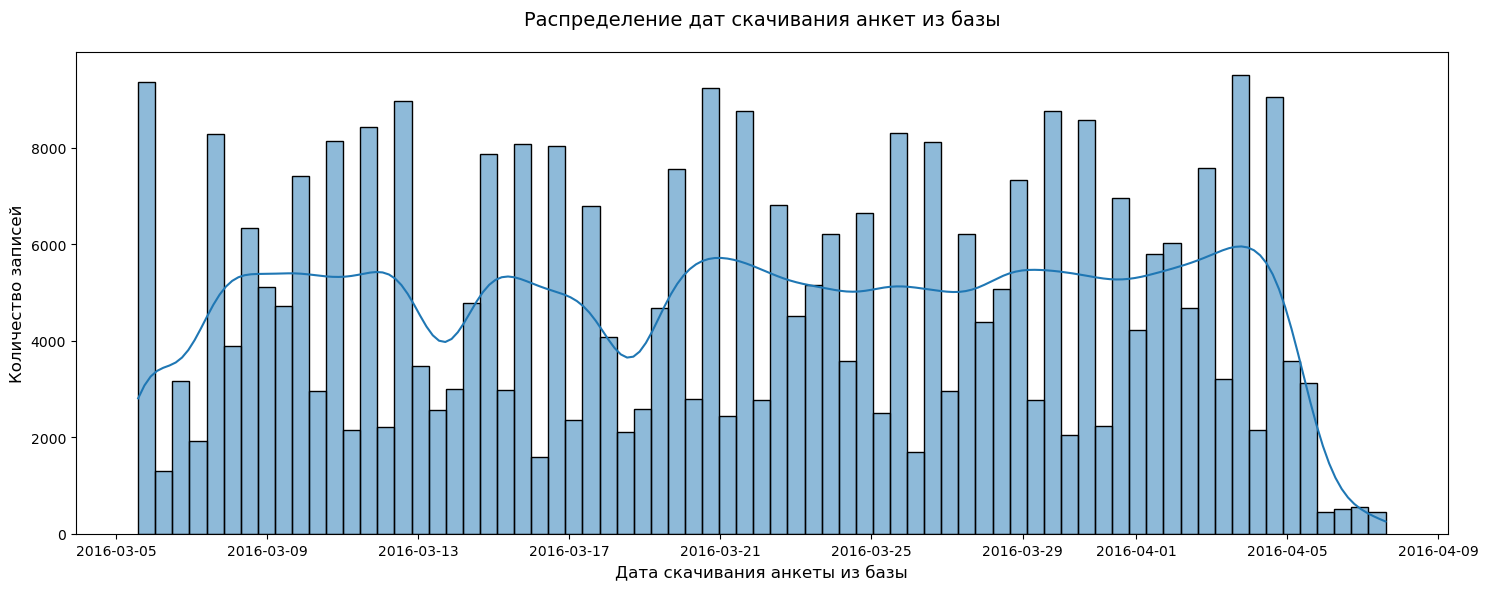

In [16]:
# для данного столбца построим только гистограмму, так как в нем присутствуют данные типа 'datetime'
# создание графика
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=data, x='date_crawled', kde=True)

# создание заголовков и подписей
ax.set_title(
    'Распределение дат скачивания анкет из базы',
    fontsize=14,
    pad=20)

ax.set_xlabel(
    'Дата скачивания анкеты из базы',
    fontsize=12)

ax.set_ylabel(
    'Количество записей',
    fontsize=12)

# окончательная настройка графика
plt.tight_layout()
plt.show()

**Примечание:** По полученному графику видно, что данные скачивались с 5 марта 2016 года по 9 апреля 2016 года, данные скачивались не ежедневно, а спромежутком в 4 дня, причем в каждую дату скачивания было разное количество информации. Данный признак будет не сильно информативен при построении моделей для предления стоимости, поэтому в будущем его можно удалить.

### 2.2 Предобработка и исследовательский анализ данных в столбце 'price'

In [17]:
# посмотрим описательную статистику целевого признака 'price'
data['price'].describe().to_frame()

,price
count,354365.000000
mean,4416.679830
std,4514.176349
min,0.000000
25%,1050.000000
50%,2700.000000
75%,6400.000000
max,20000.000000


In [18]:
# посмотрим количество пропусков в столбце 'price'
data['price'].isna().sum()

0

In [19]:
# построение графиков для разных типов признаков (количественных и категориальных)
# напишем собственную функцию для визуализации количественных признаков
def numeric(data, column, title):
    # устанавливаем параметры графика
    sns.set_style("whitegrid")
    
    # создаем подграфики (фигура с двумя графиками: по одниму в стрпоке)
    fig, (hist_ax, box_ax) = plt.subplots(
        nrows=2,
        figsize=(12, 9),
        sharex=True,
        gridspec_kw={'height_ratios': [5, 1]}
    )
    
    # построение гистограммы
    sns.histplot(
        data=data,
        x=column,
        kde=True,
        ax=hist_ax
    ).set(
        ylabel='Количество записей')
    
    # построение графика "Ящик с усами"
    sns.boxplot(
        data=data,
        x=column,
        ax=box_ax
    ).set(xlabel=column)
    
    # окончательная настройка графика
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

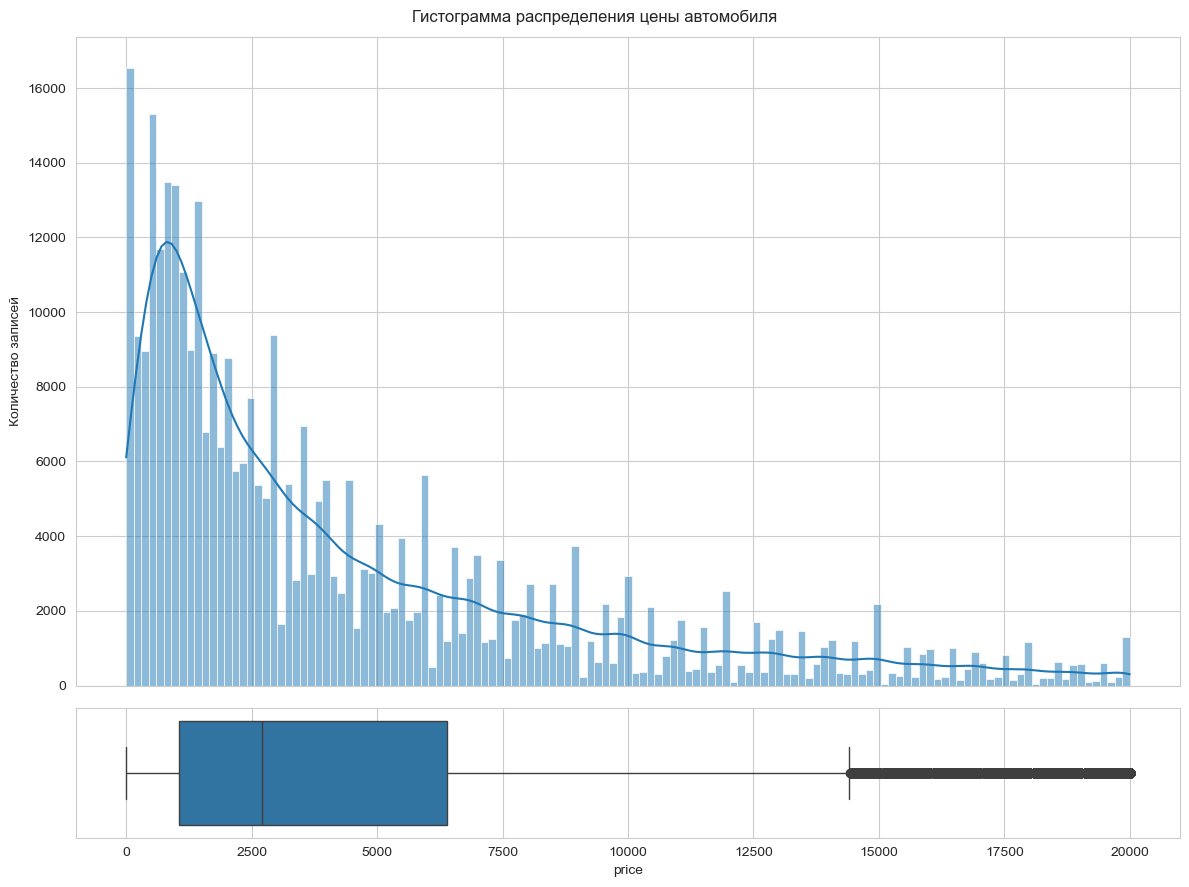

In [20]:
# визуализация признака 'price'
numeric(data, 'price', 'Гистограмма распределения цены автомобиля')

In [22]:
# посмотрим количество автомобилей со стоимость меньше 1000
data.loc[data['price'] < 1000]['price'].count()

83326

In [23]:
# сформируем срез данных
data_new = data.query('price > 1000')

In [24]:
# проверим корректность среза
data_new.loc[data_new['price'] < 1000]['price'].count()

0

In [25]:
# посмотрим общую информацию о новой таблице
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266391 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        266391 non-null  datetime64[ns]
 1   price               266391 non-null  int64         
 2   vehicle_type        246829 non-null  object        
 3   registration_year   266391 non-null  int64         
 4   gearbox             256573 non-null  object        
 5   power               266391 non-null  int64         
 6   model               255364 non-null  object        
 7   kilometer           266391 non-null  int64         
 8   registration_month  266391 non-null  int64         
 9   fuel_type           249770 non-null  object        
 10  brand               266391 non-null  object        
 11  repaired            225859 non-null  object        
 12  date_created        266391 non-null  datetime64[ns]
 13  number_of_pictures  266391 non-nul

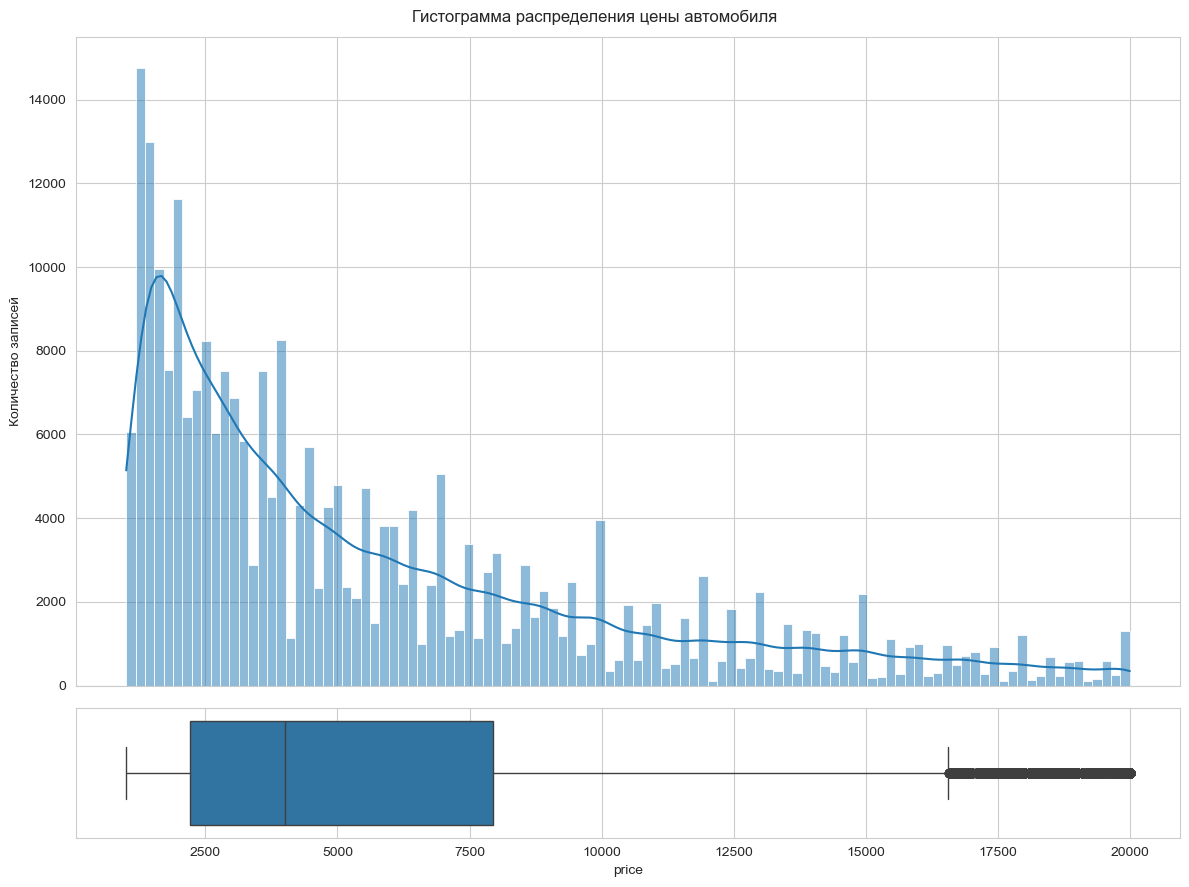

In [26]:
# снова визуализируем признак 'price'
numeric(data_new, 'price', 'Гистограмма распределения цены автомобиля')

**Примечание:** Исходное распределение не изменилось, но аномальные данные ушли.

### 2.3 Предобработка и исследовательский анализ данных в столбце 'vehicle_type'

In [27]:
# посмотрим описательную статистику признака 'vehicle_type'
data_new['vehicle_type'].describe().to_frame()

,vehicle_type
count,246829
unique,8
top,sedan
freq,73048


In [28]:
# в данном столбце таблицы присутствуют пропуски, посмотрим их количество
data_new['vehicle_type'].isna().sum()

19562

In [29]:
# посмотрим количество каждого уникального значения для этого столбца с указанием количества пропущенных значений
data_new['vehicle_type'].value_counts(dropna=False)

vehicle_type
sedan          73048
wagon          52436
small          50042
bus            25751
NaN            19562
convertible    18605
coupe          13239
suv            11421
other           2287
Name: count, dtype: int64

In [30]:
# напишем собственную функцию для визулизации категориальных признаков
def categorical(data, column, title, figsize=(15, 8)):
    # устанавливаем параметры графика
    sns.set(style="whitegrid")
    plt.figure(figsize=figsize)
    
    # создаем график
    ax = sns.countplot(data = data, x=column, palette="viridis")
    
    # добавляем процентное соотношение по признакам
    total = len(data)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2.,
                height + 0.01 * total,
                f'{height/total:.1%}',
                ha="center")

    # окончательная настройка графика
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Количество записей')
    plt.xticks()
    plt.tight_layout()
    plt.show()

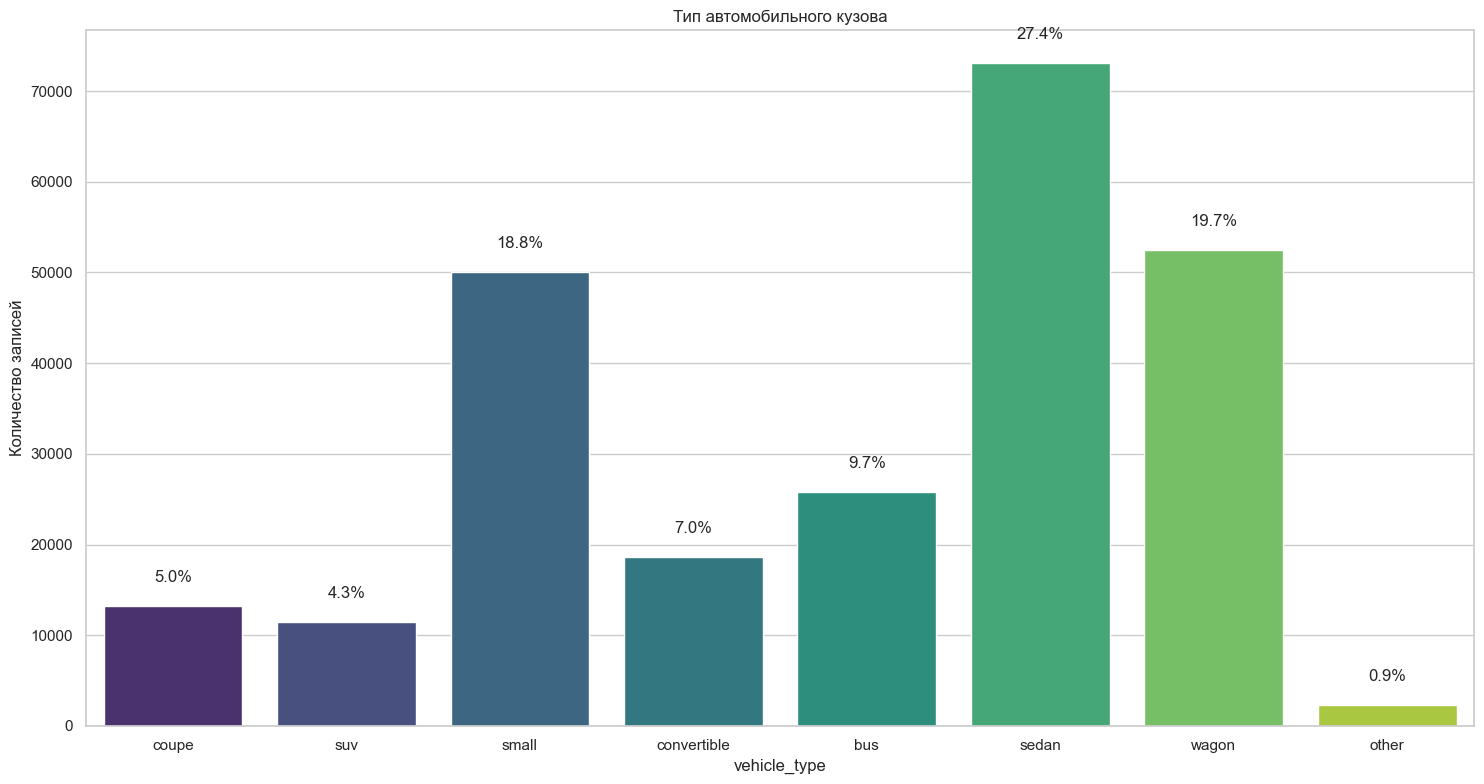

In [31]:
# визуализация признака 'vehicle_type'
categorical(data_new, 'vehicle_type', 'Тип автомобильного кузова')

**Примечание:** В столбце 'vehicle_type' присутствует 33653 пропущенных значений, что достаточно много. Оставлять эти значения пропущенными или заполнить наиболее часто встречающимся значением - неправильно. При заполнении данных пропусков необходимо проанализировать, для каких брендов автомобилей они чаще всего встречаются и какие типы кузова характерны для них.

In [32]:
# создадим словарь с наиболее частыми типами кузова для конкретных марок автомобилей
vehicle_type_dict = (data_new.groupby('brand')['vehicle_type'].apply(lambda x: x.mode()[0]).to_dict())

In [33]:
# посмотрим словарь, который получился
vehicle_type_dict

{'alfa_romeo': 'sedan',
 'audi': 'wagon',
 'bmw': 'sedan',
 'chevrolet': 'small',
 'chrysler': 'bus',
 'citroen': 'small',
 'dacia': 'wagon',
 'daewoo': 'small',
 'daihatsu': 'small',
 'fiat': 'small',
 'ford': 'small',
 'honda': 'sedan',
 'hyundai': 'small',
 'jaguar': 'sedan',
 'jeep': 'suv',
 'kia': 'suv',
 'lada': 'suv',
 'lancia': 'small',
 'land_rover': 'suv',
 'mazda': 'sedan',
 'mercedes_benz': 'sedan',
 'mini': 'small',
 'mitsubishi': 'sedan',
 'nissan': 'small',
 'opel': 'small',
 'peugeot': 'small',
 'porsche': 'convertible',
 'renault': 'small',
 'rover': 'sedan',
 'saab': 'sedan',
 'seat': 'small',
 'skoda': 'wagon',
 'smart': 'small',
 'sonstige_autos': 'suv',
 'subaru': 'wagon',
 'suzuki': 'suv',
 'toyota': 'small',
 'trabant': 'sedan',
 'volkswagen': 'sedan',
 'volvo': 'wagon'}

In [34]:
# заполним пропуски на основе найденных типов кузова для конкретных марок автомобилей
mask = data_new['vehicle_type'].isna()
data_new.loc[mask, 'vehicle_type'] = data_new.loc[mask, 'brand'].apply(lambda x: vehicle_type_dict.get(x))

In [35]:
# проверим количество пропусков после их заполнения
data_new['vehicle_type'].value_counts(dropna=False)

vehicle_type
sedan          82630
small          57367
wagon          54395
bus            25825
convertible    18635
coupe          13239
suv            12013
other           2287
Name: count, dtype: int64

In [36]:
data_new['vehicle_type'].isna().sum()

0

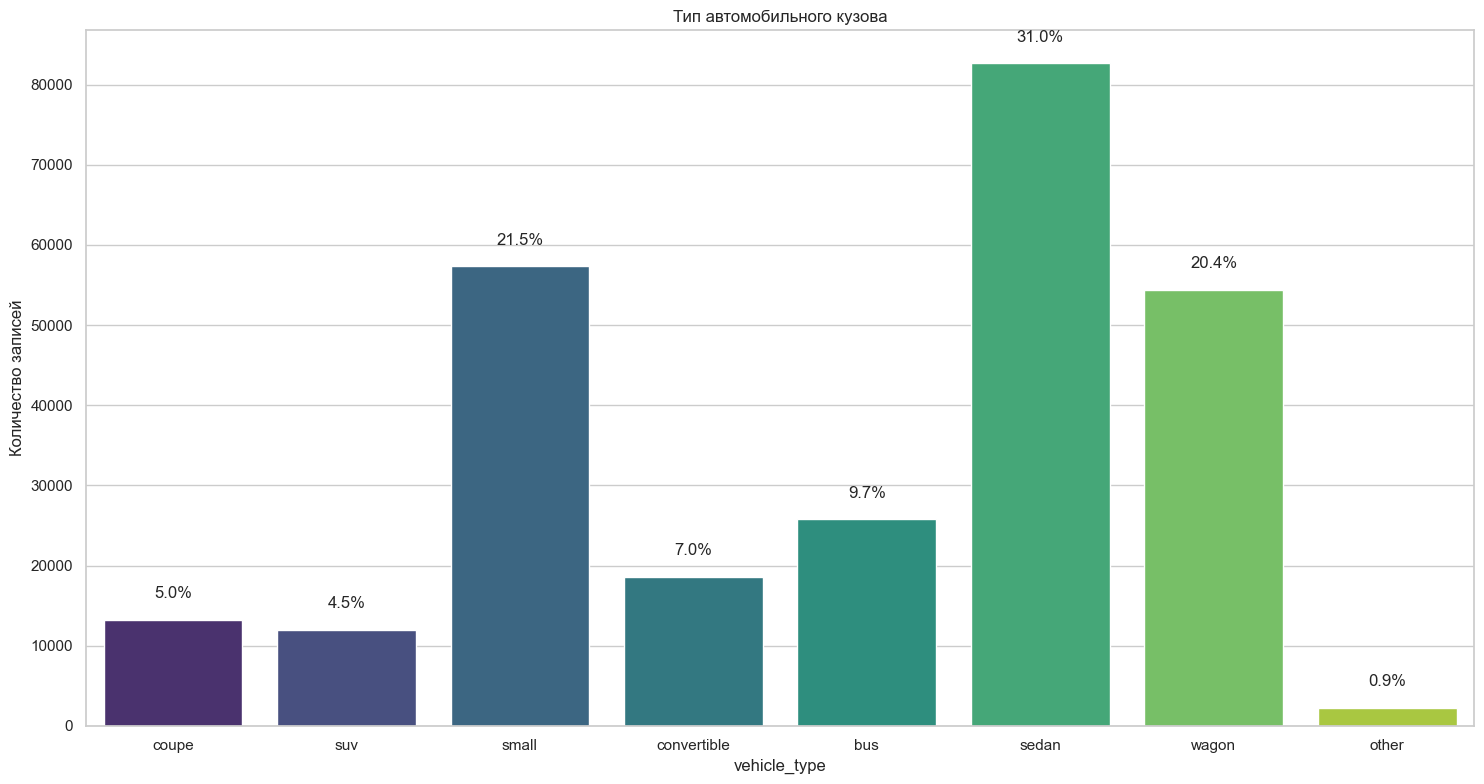

In [37]:
# снова визуализируем признак 'vehicle_type'
categorical(data_new, 'vehicle_type', 'Тип автомобильного кузова')

**Примечание:** Пропуски в столбце 'vehicle_type' полностью обработаны. Лидерами среди типов автомобильного кузова все равно остались: 'sedan', 'small' и 'wagon'.

### 2.4 Предобработка и исследовательский анализ данных в столбце 'registration_year'

In [38]:
# посмотрим описательную статистику признака 'registration_year'
data_new['registration_year'].describe().to_frame()

,registration_year
count,266391.000000
mean,2004.785623
std,56.597238
min,1000.000000
25%,2001.000000
50%,2005.000000
75%,2008.000000
max,9999.000000


In [39]:
# посмотрим количество пропусков в столбце 'registration_year'
data_new['registration_year'].isna().sum()

0

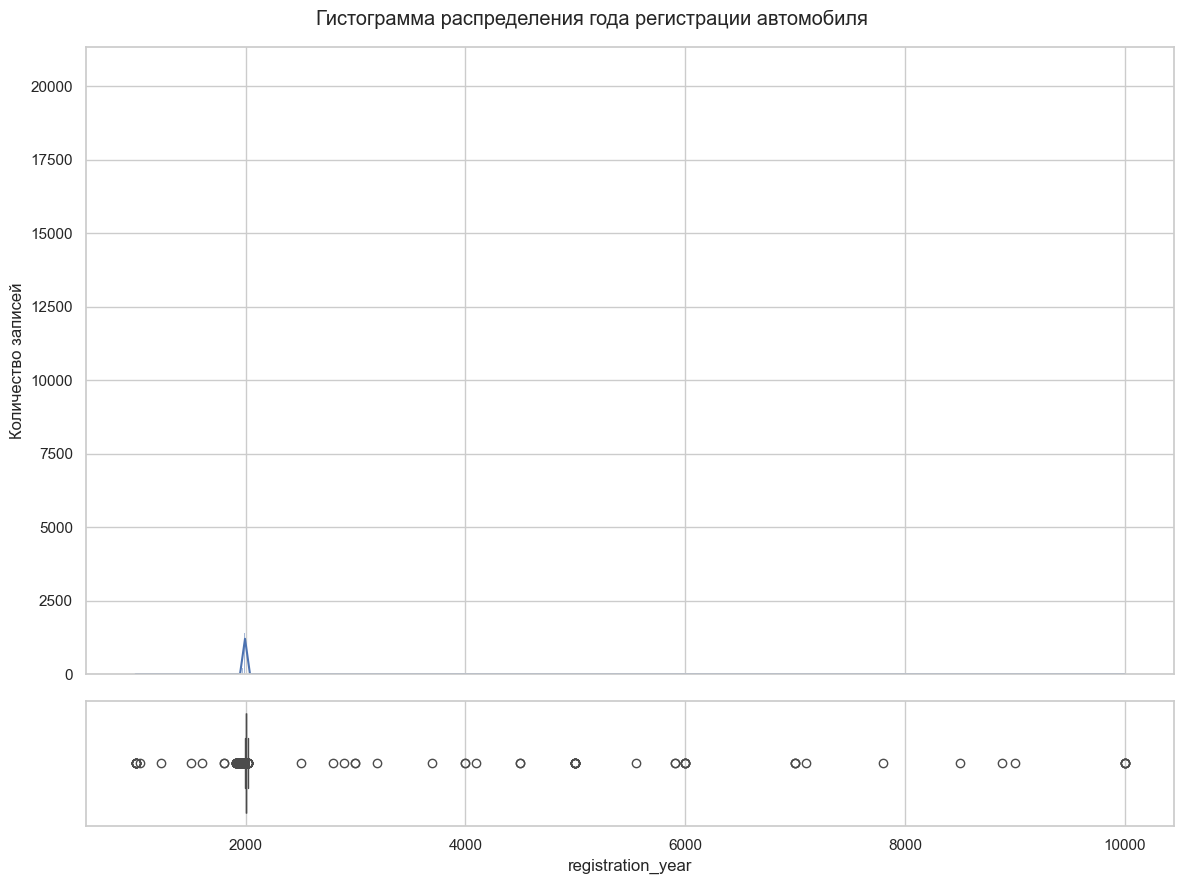

In [40]:
# визуализируем признак 'registration_year'
numeric(data_new, 'registration_year', 'Гистограмма распределения года регистрации автомобиля')

**Примечание:** Графики получились очень плохими, на них очень много выбросов, которые не соответствуют действительности, их стоит почистить. Для начала, чтобы не сильно портить весь пласт данных, уберем с обеих сторон по 1% аномально маленьких и аномально больших значений.

In [41]:
# сформируем срез данных
data_new_year = data_new[(data_new['registration_year'] > data_new['registration_year'].quantile(.01)) 
                         & (data_new['registration_year'] < data_new['registration_year'].quantile(.99))].copy()

In [42]:
# посмотрим общую информацию о новой таблице
data_new_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 260354 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        260354 non-null  datetime64[ns]
 1   price               260354 non-null  int64         
 2   vehicle_type        260354 non-null  object        
 3   registration_year   260354 non-null  int64         
 4   gearbox             251284 non-null  object        
 5   power               260354 non-null  int64         
 6   model               250411 non-null  object        
 7   kilometer           260354 non-null  int64         
 8   registration_month  260354 non-null  int64         
 9   fuel_type           245372 non-null  object        
 10  brand               260354 non-null  object        
 11  repaired            221790 non-null  object        
 12  date_created        260354 non-null  datetime64[ns]
 13  number_of_pictures  260354 non-nul

In [43]:
# снова посмотрим описательную статистику признака 'registration_year'
data_new_year['registration_year'].describe().to_frame()

,registration_year
count,260354.000000
mean,2004.413191
std,5.936387
min,1980.000000
25%,2001.000000
50%,2005.000000
75%,2008.000000
max,2017.000000


In [44]:
# по полученным результатам срез данных почти идеальный, но стоит убрать 2017 год, т.к.данные скачивались за 2016 год
data_new_year = data_new_year[data_new_year['registration_year'] < 2017].copy()

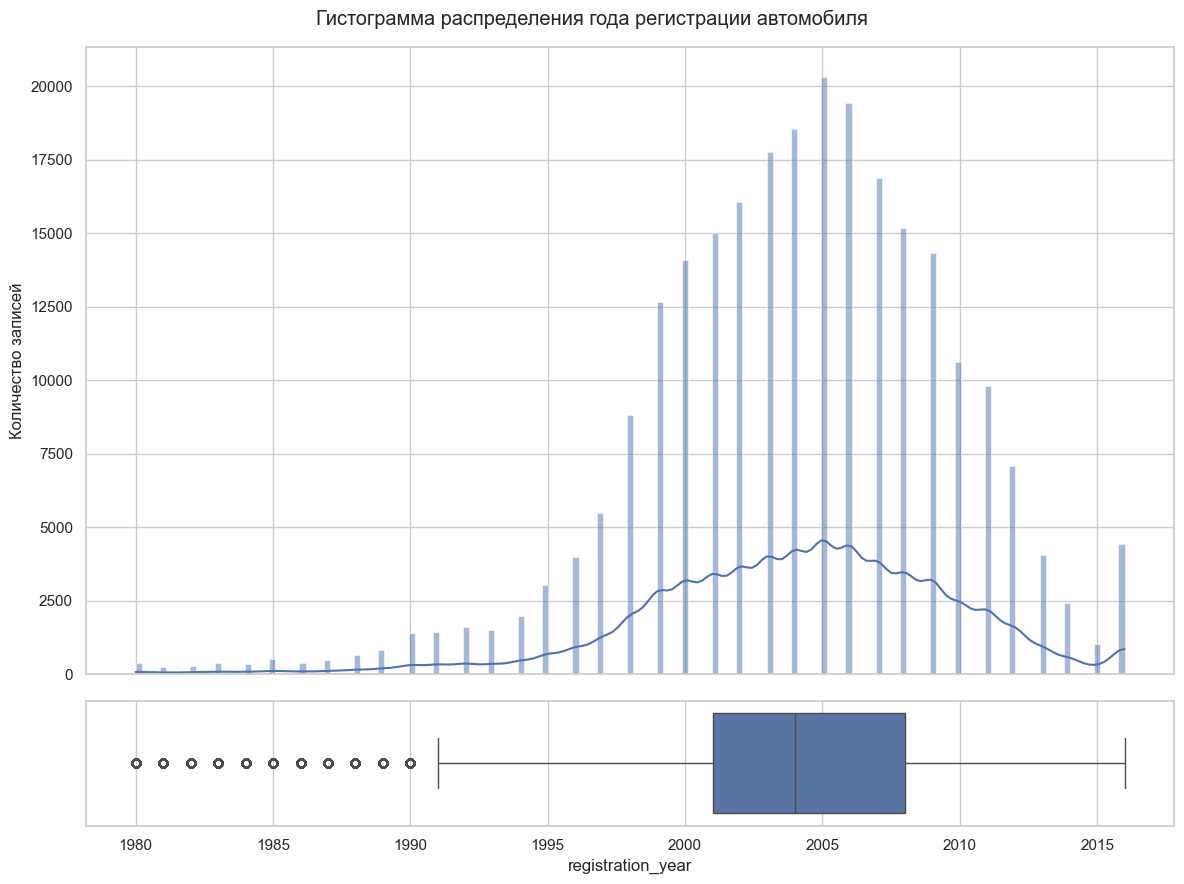

In [45]:
# снова визуализируем признак 'registration_year'
numeric(data_new_year, 'registration_year', 'Гистограмма распределения года регистрации автомобиля')

**Примечание:** Теперь распределение автомобилей по годам регистрации похоже на действительность. Заметно, что продается достаточно много автомобилей, зарегистрированных в период с 1980 по 1995 годы, а также после небольшого спада, начиная с 2007 года, виден всплеск продажи автомобилей, зарегистрированных в 2016 году.

### 2.5 Предобработка и исследовательский анализ данных в столбце 'gearbox'

In [46]:
# посмотрим описательную статистику признака 'gearbox'
data_new_year['gearbox'].describe().to_frame()

,gearbox
count,244913
unique,2
top,manual
freq,188433


In [47]:
# в данном столбце таблицы присутствуют пропуски, посмотрим их количество
data_new_year['gearbox'].isna().sum()

8350

In [48]:
# посмотрим количество каждого уникального значения для этого столбца с указанием количества пропущенных значений
data_new_year['gearbox'].value_counts(dropna=False)

gearbox
manual    188433
auto       56480
NaN         8350
Name: count, dtype: int64

**Примечание:** Столбец с информацией о корбкe передач достаточно важный параметр, который сильно может повлиять на обучение моделей. Чтобы не заполнять пропущенные значения ошибочными данными, их лучше удалить в целях избежания искажения данных.

In [49]:
# удалим пропущенные значения
data_new_year.dropna(subset=['gearbox'], inplace=True)

In [50]:
# проверим столбец на наличие пропущенных значений
data_new_year['gearbox'].unique()

array(['manual', 'auto'], dtype=object)

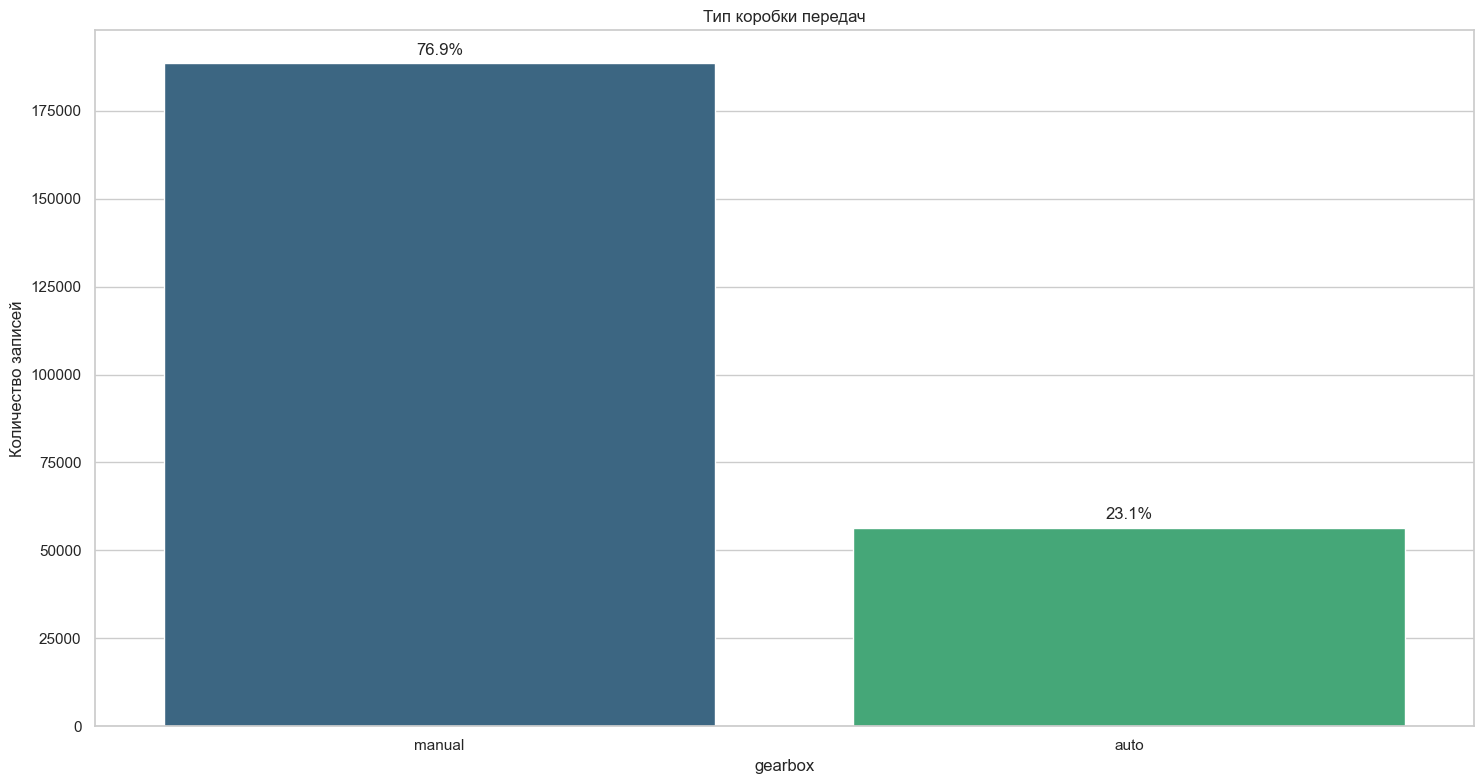

In [51]:
# визуализация признака 'gearbox'
categorical(data_new_year, 'gearbox', 'Тип коробки передач')

In [52]:
data_new_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244913 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        244913 non-null  datetime64[ns]
 1   price               244913 non-null  int64         
 2   vehicle_type        244913 non-null  object        
 3   registration_year   244913 non-null  int64         
 4   gearbox             244913 non-null  object        
 5   power               244913 non-null  int64         
 6   model               236902 non-null  object        
 7   kilometer           244913 non-null  int64         
 8   registration_month  244913 non-null  int64         
 9   fuel_type           234932 non-null  object        
 10  brand               244913 non-null  object        
 11  repaired            213425 non-null  object        
 12  date_created        244913 non-null  datetime64[ns]
 13  number_of_pictures  244913 non-nul

### 2.6 Предобработка и исследовательский анализ данных в столбце 'power'

In [53]:
# посмотрим описательную статистику признака 'power'
data_new_year['power'].describe().to_frame()

,power
count,244913.000000
mean,125.994341
std,188.226657
min,0.000000
25%,85.000000
50%,116.000000
75%,150.000000
max,20000.000000


In [54]:
# посмотрим количество пропусков в столбце 'power'
data_new_year['power'].isna().sum()

0

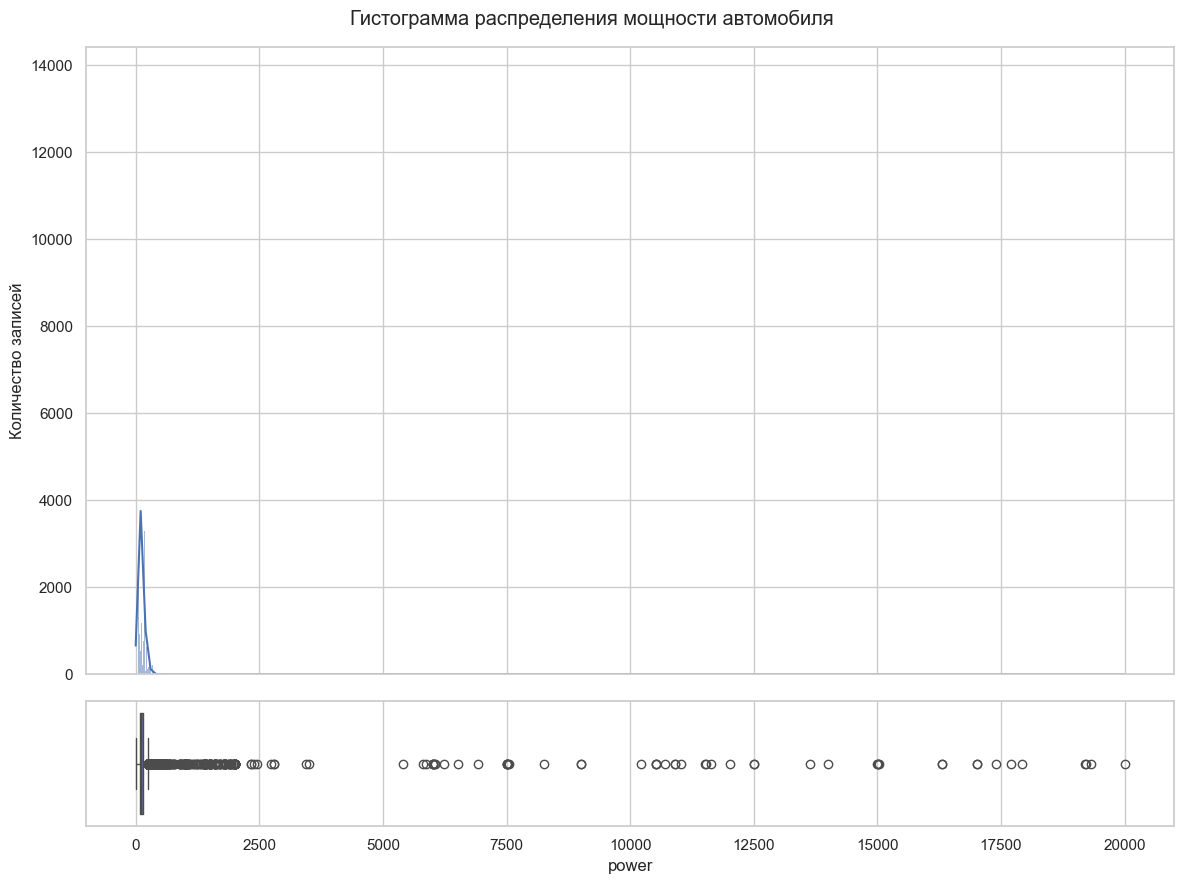

In [55]:
# визуализируем признак 'power'
numeric(data_new_year, 'power', 'Гистограмма распределения мощности автомобиля')

**Примечание:** Графики получились очень плохими, на них очень много выбросов, которые не соответствуют действительности, их стоит почистить. Для начала, чтобы не сильно портить весь пласт данных, уберем с обеих сторон по 1% аномально маленьких и аномально больших значений.

In [56]:
# сформируем срез данных (СТАРЫЙ)
# data_new_year = data_new_year[(data_new_year['power'] > data_new_year['power'].quantile(.01)) & (data_new_year['power'] < data_new_year['power'].quantile(.99))].copy()

In [57]:
data_new_year = data_new_year.query('power > 50 & power < 350')

In [58]:
# посмотрим информацию о сформированном наборе данных
data_new_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228370 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        228370 non-null  datetime64[ns]
 1   price               228370 non-null  int64         
 2   vehicle_type        228370 non-null  object        
 3   registration_year   228370 non-null  int64         
 4   gearbox             228370 non-null  object        
 5   power               228370 non-null  int64         
 6   model               221910 non-null  object        
 7   kilometer           228370 non-null  int64         
 8   registration_month  228370 non-null  int64         
 9   fuel_type           220194 non-null  object        
 10  brand               228370 non-null  object        
 11  repaired            202628 non-null  object        
 12  date_created        228370 non-null  datetime64[ns]
 13  number_of_pictures  228370 non-nul

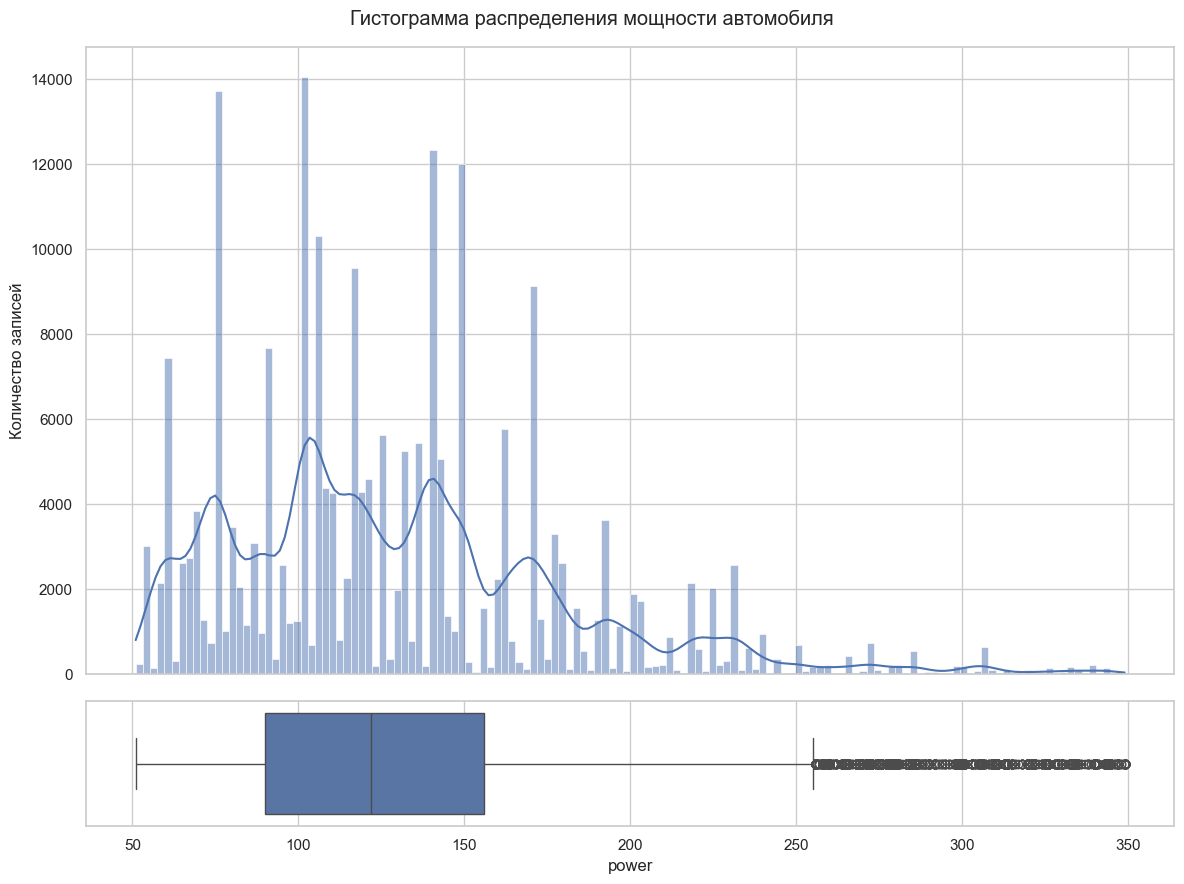

In [59]:
# снова визуализируем признак 'power'
numeric(data_new_year, 'power', 'Гистограмма распределения мощности автомобиля')

**Примечание:** После осуществления среза данных распределение больше похоже на правду, существует пик данных на величине, равной примерно 75 лошадиных сил.

### 2.7 Предобработка и исследовательский анализ данных в столбце 'model

In [60]:
# посмотрим описательную статистику признака 'model'
data_new_year['model'].describe().to_frame()

,model
count,221910
unique,247
top,golf
freq,19133


In [61]:
# в данном столбце таблицы присутствуют пропуски, посмотрим их количество
data_new_year['model'].isna().sum()

6460

In [62]:
# посмотрим количество каждого уникального значения для этого столбца с указанием количества пропущенных значений
data_new_year['model'].value_counts(dropna=False)

model
golf                  19133
3er                   15054
other                 14574
a4                     7664
passat                 7395
                      ...  
rangerover                2
range_rover_evoque        2
serie_2                   2
samara                    2
elefantino                1
Name: count, Length: 248, dtype: int64

**Примечание:** В нашем наборе данных присутствует 249 уникальных моделей автомобилей, построение графика в данном случае нецелесообразно, так как он будет содержать в себе множество наложений (P.S.: была попытка построить график). Но также столбец с информацией о модели автомобиля имеет сильное влияние на формирование его цены, поэтому заменять его на какие-то альтернативы будет неправильным. Пропуски в данном столбце будут просто удалены.

In [63]:
# удаление пропусков
data_new_year = data_new_year.dropna(axis=0, subset=['model'])

In [64]:
# проверим столбец на наличие пропущенных значений после удаления уже обнаруженных
data_new_year['model'].isna().sum()

0

**Примечание:** Пропуски в столбце 'model' успешно удалены.

### 2.8 Предобработка и исследовательский анализ данных в столбце 'kilometer'

In [65]:
# посмотрим описательную статистику признака 'kilometer'
data_new_year['kilometer'].describe().to_frame()

,kilometer
count,221910.000000
mean,125639.944121
std,37826.919203
min,5000.000000
25%,100000.000000
50%,150000.000000
75%,150000.000000
max,150000.000000


In [66]:
# посмотрим количество пропусков в столбце 'kilometer'
data_new_year['kilometer'].isna().sum()

0

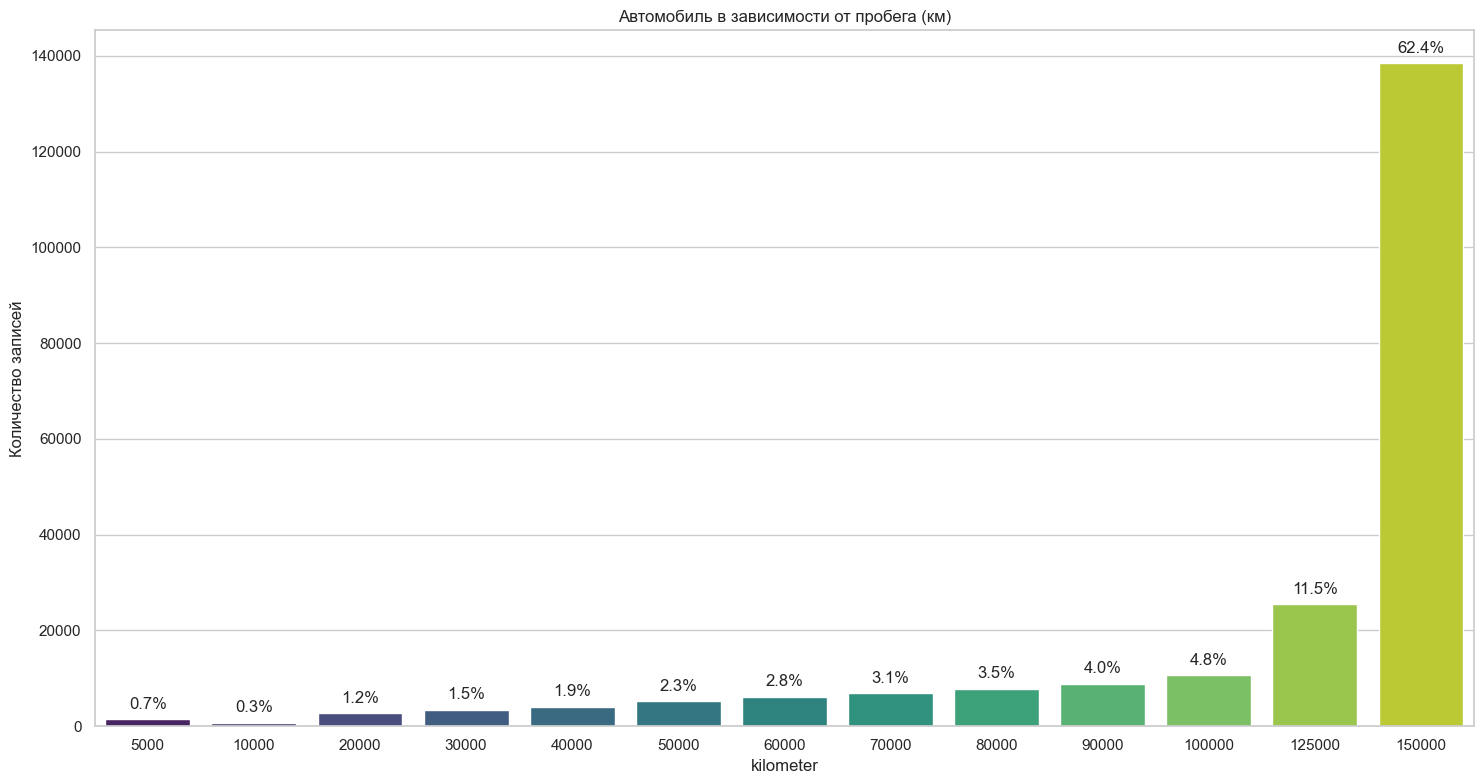

In [67]:
# визуализируем признак 'kilometer'
categorical(data_new_year, 'kilometer', 'Автомобиль в зависимости от пробега (км)')

**Примечание:** По результатам построения графика видно, что в данных присутствует большое количество автомобилей с пробегом 150000 км. Это характерно для поддержанных авто, которые уже были в использовое какое-то количество времени, и теперь продаются на сервисе "Не бит, не крашен". Также можно предположить, что отметка пробега в 150000 км. является на сервисе максимальной, поэтому эта категория в том числе включила в себя автомобили с еще большем пробегом.

### 2.9 Предобработка и исследовательский анализ данных в столбце 'registration_month'

In [68]:
# посмотрим описательную статистику признака 'registration_month'
data_new_year['registration_month'].describe().to_frame()

,registration_month
count,221910.000000
mean,6.196449
std,3.494457
min,0.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,12.000000


In [69]:
# посмотрим количество пропусков в столбце 'registration_month'
data_new_year['registration_month'].isna().sum()

0

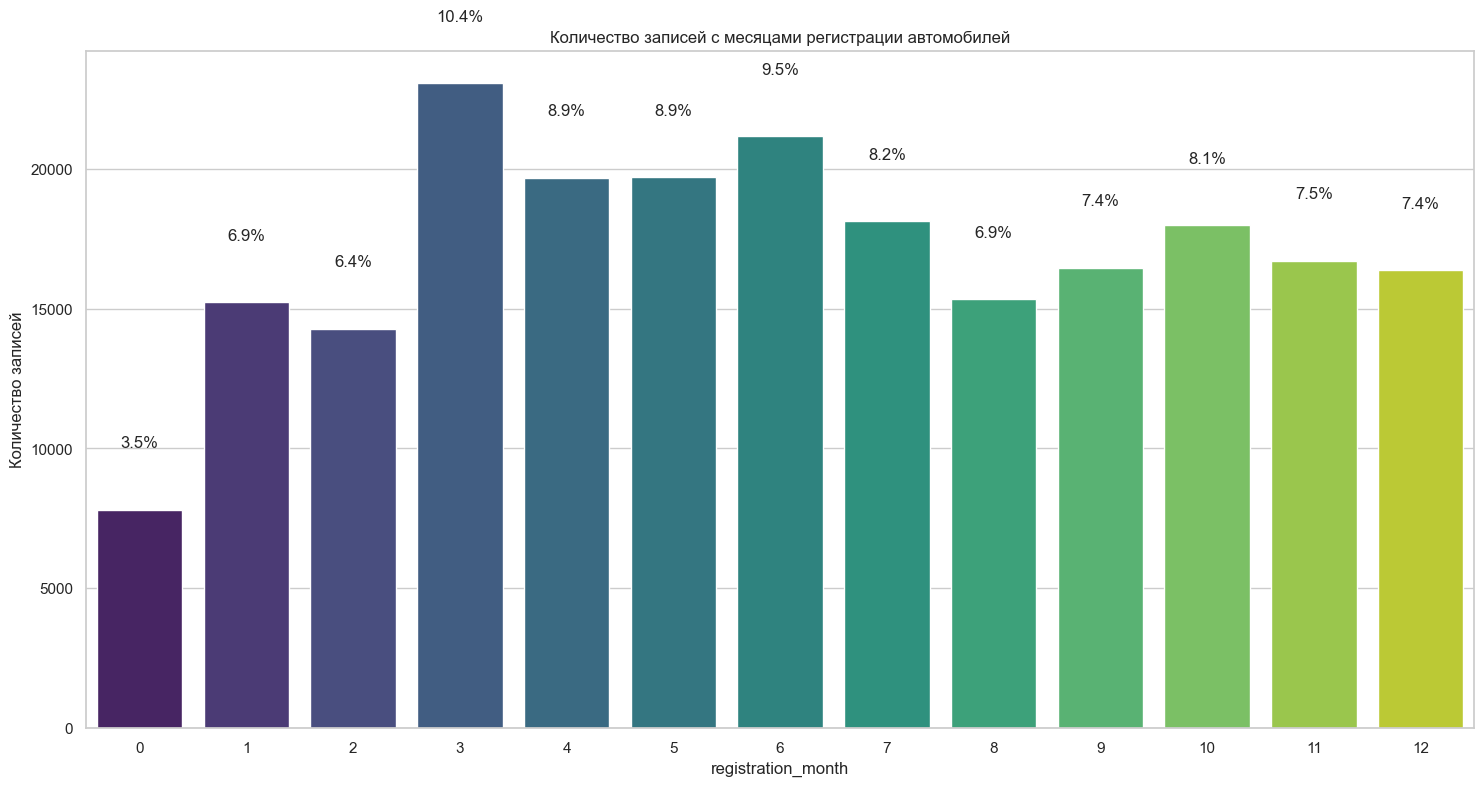

In [70]:
# визуализируем признак 'registration_month'
categorical(data_new_year, 'registration_month', 'Количество записей с месяцами регистрации автомобилей')

**Примечание:** График получился хорошим, но есть одно "НО", в году 12 месяцев, но почему-то при построении столбца 'registration_month' их получилось 13. Возможно, это может быть связано с нумерацией в Pandas, которая начинается с 0. Не будем ничего делать с данным столбцом, чтобы не портить наши остальные данные. Признак 'registration_month' будет не сильно информативен для исследования, поэтому в построение модели не будем его брать.

### 2.10 Предобработка и исследовательский анализ данных в столбце 'fuel_type'

In [71]:
# посмотрим описательную статистику признака 'fuel_type'
data_new_year['fuel_type'].describe().to_frame()

,fuel_type
count,215070
unique,7
top,petrol
freq,130410


In [72]:
# посмотрим количество пропусков в столбце 'fuel_type'
data_new_year['fuel_type'].isna().sum()

6840

In [73]:
# посмотрим количество каждого уникального значения для этого столбца с указанием количества пропущенных значений
data_new_year['fuel_type'].value_counts(dropna=False)

fuel_type
petrol      130410
gasoline     80272
NaN           6840
lpg           3740
cng            423
hybrid         170
other           31
electric        24
Name: count, dtype: int64

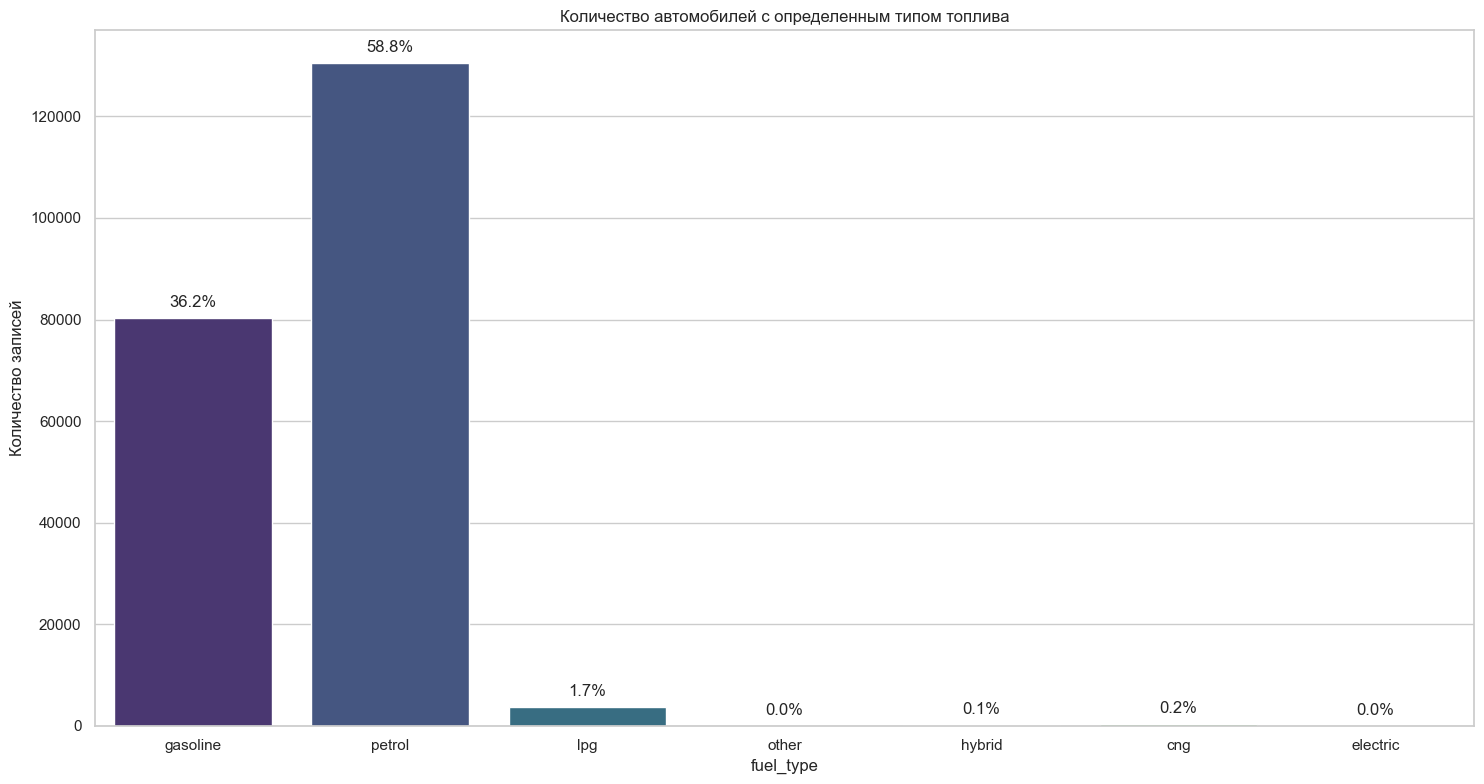

In [74]:
# визуализируем признак 'fuel_type'
categorical(data_new_year, 'fuel_type', 'Количество автомобилей с определенным типом топлива')

**Примечание:** Для большинства автомобилей используется топливо 'petrol', на втором месте 'gasoline'. Также в данных присутствуют пропуски, заполним их в зависимости от типа автомобиля.

In [75]:
# создадим словарь с наиболее частыми типами топлива для конкретных типов автомобилей
fuel_type_dict = (data_new_year.groupby('vehicle_type')['fuel_type'].apply(lambda x: x.mode()[0]).to_dict())

In [76]:
# посмотрим словарь, который получился
fuel_type_dict

{'bus': 'gasoline',
 'convertible': 'petrol',
 'coupe': 'petrol',
 'other': 'gasoline',
 'sedan': 'petrol',
 'small': 'petrol',
 'suv': 'gasoline',
 'wagon': 'gasoline'}

In [77]:
# заполним пропуски на основе найденных типов топлива для конкретных типов автомобилей
mask_1 = data_new_year['fuel_type'].isna()
data_new_year.loc[mask_1, 'fuel_type'] = data_new_year.loc[mask_1, 'vehicle_type'].apply(lambda x: fuel_type_dict.get(x))

In [78]:
# проверим количество пропусков после их заполнения
data_new_year['fuel_type'].value_counts(dropna=False)

fuel_type
petrol      134942
gasoline     82580
lpg           3740
cng            423
hybrid         170
other           31
electric        24
Name: count, dtype: int64

In [79]:
data_new_year['fuel_type'].isna().sum()

0

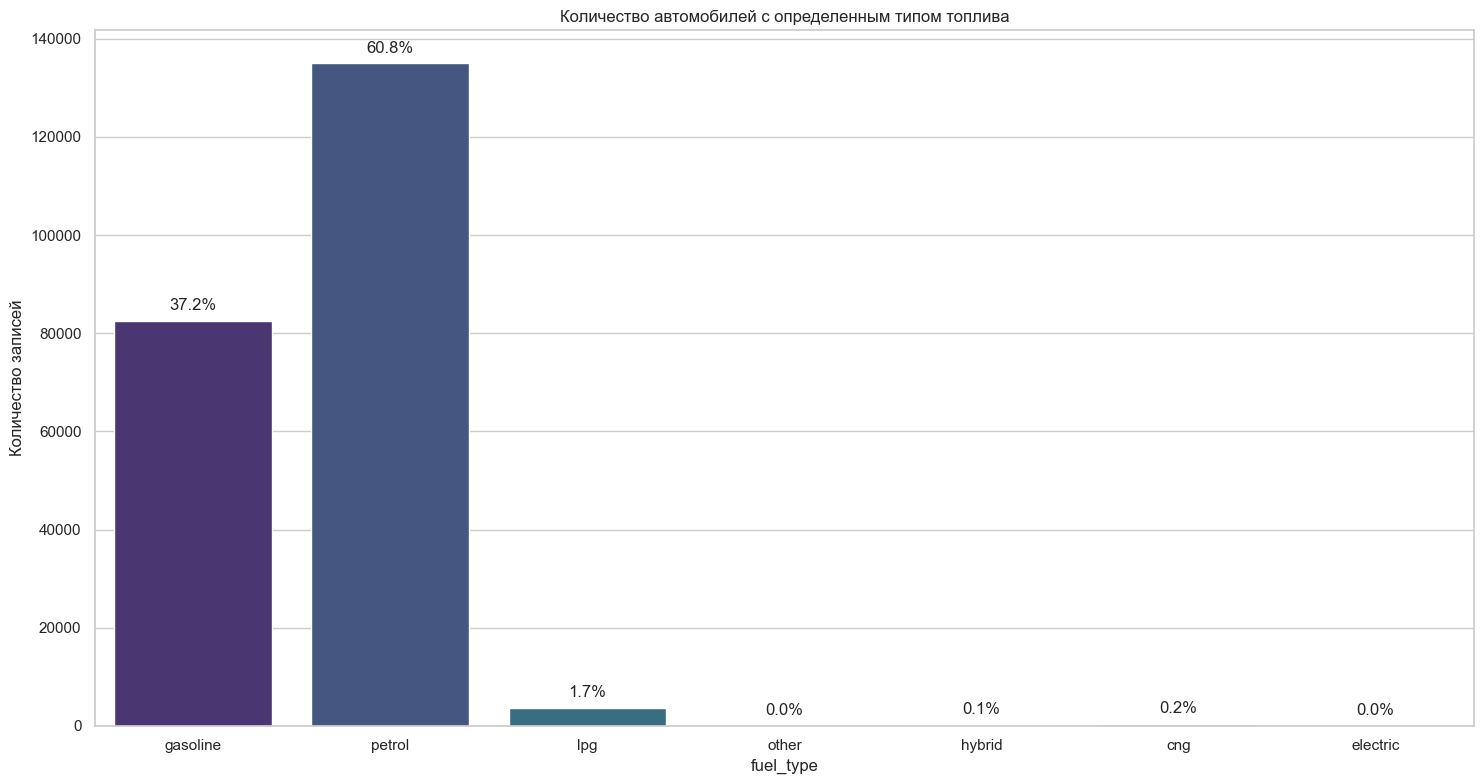

In [80]:
# снова визуализируем признак 'fuel_type'
categorical(data_new_year, 'fuel_type', 'Количество автомобилей с определенным типом топлива')

**Примечание:** После заполнения всех пропущенных значений, лидерами среди типов топлива все равно остались: 'petrol' и 'gasoline'.

### 2.11 Предобработка и исследовательский анализ данных в столбце 'brand'

In [81]:
# посмотрим описательную статистику признака 'brand'
data_new_year['brand'].describe().to_frame()

,brand
count,221910
unique,39
top,volkswagen
freq,47683


In [82]:
# посмотрим количество пропусков в столбце 'brand'
data_new_year['brand'].isna().sum()

0

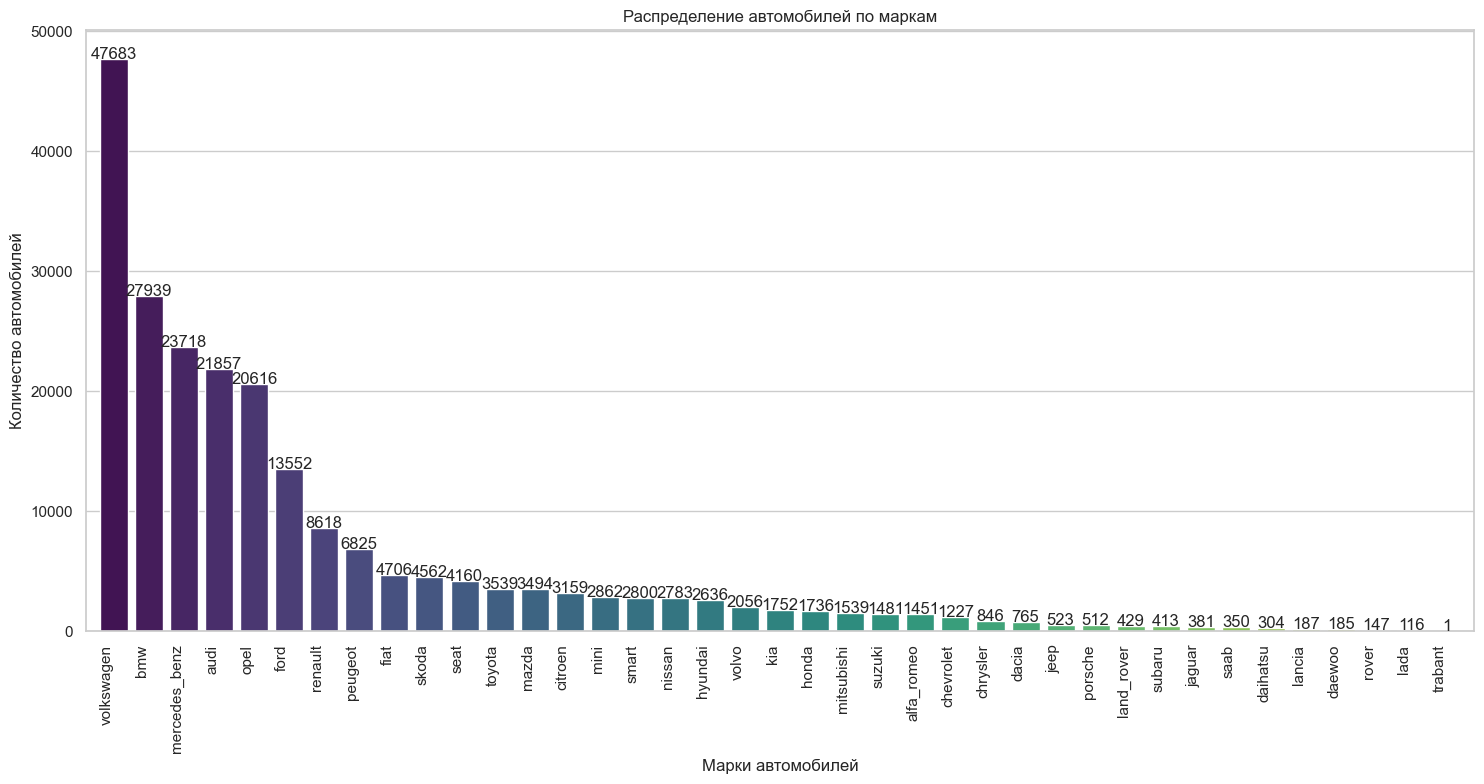

In [83]:
# визуализируем признак 'brand'
# для этого признака присутствует 39 различных значений, поэтому построим для него индивидуальный график

# устанавливаем параметры графика
plt.figure(figsize=(15, 8))

# создаем график
ax = sns.countplot(
    data=data_new_year,
    x='brand',
    order=data_new_year['brand'].value_counts().index, 
    palette='viridis' 
)

# настройка подписей
ax.set(
    xlabel='Марки автомобилей',
    ylabel='Количество автомобилей',
    title='Распределение автомобилей по маркам',
    xmargin=0.01
)

plt.xticks(
    rotation=90,
    ha='right'  
)

# добавляем процентное соотношение по признакам
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.0f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center'
    )

# окончательная настройка графика
plt.tight_layout()
plt.show()

**Примечание:** В данном столбце с признаком отсутствуют пропущенные значения, что очень хорошо для исследования, так как данный признак будет очень информативным при построении моделей. По результатам построения графика видно, что наиболее популярными марками автомобилей являются: 'volkswagen', 'opel', bmw', 'mercedes_benz' и 'audi'.

### 2.12 Предобработка и исследовательский анализ данных в столбце 'repaired'

In [84]:
# посмотрим описательную статистику признака 'repaired'
data_new_year['repaired'].describe().to_frame()

,repaired
count,198070
unique,2
top,no
freq,184834


In [85]:
# посмотрим количество пропусков в столбце 'repaired'
data_new_year['repaired'].isna().sum()

23840

In [86]:
# посмотрим количество каждого уникального значения для этого столбца с указанием количества пропущенных значений
data_new_year['repaired'].value_counts(dropna=False)

repaired
no     184834
NaN     23840
yes     13236
Name: count, dtype: int64

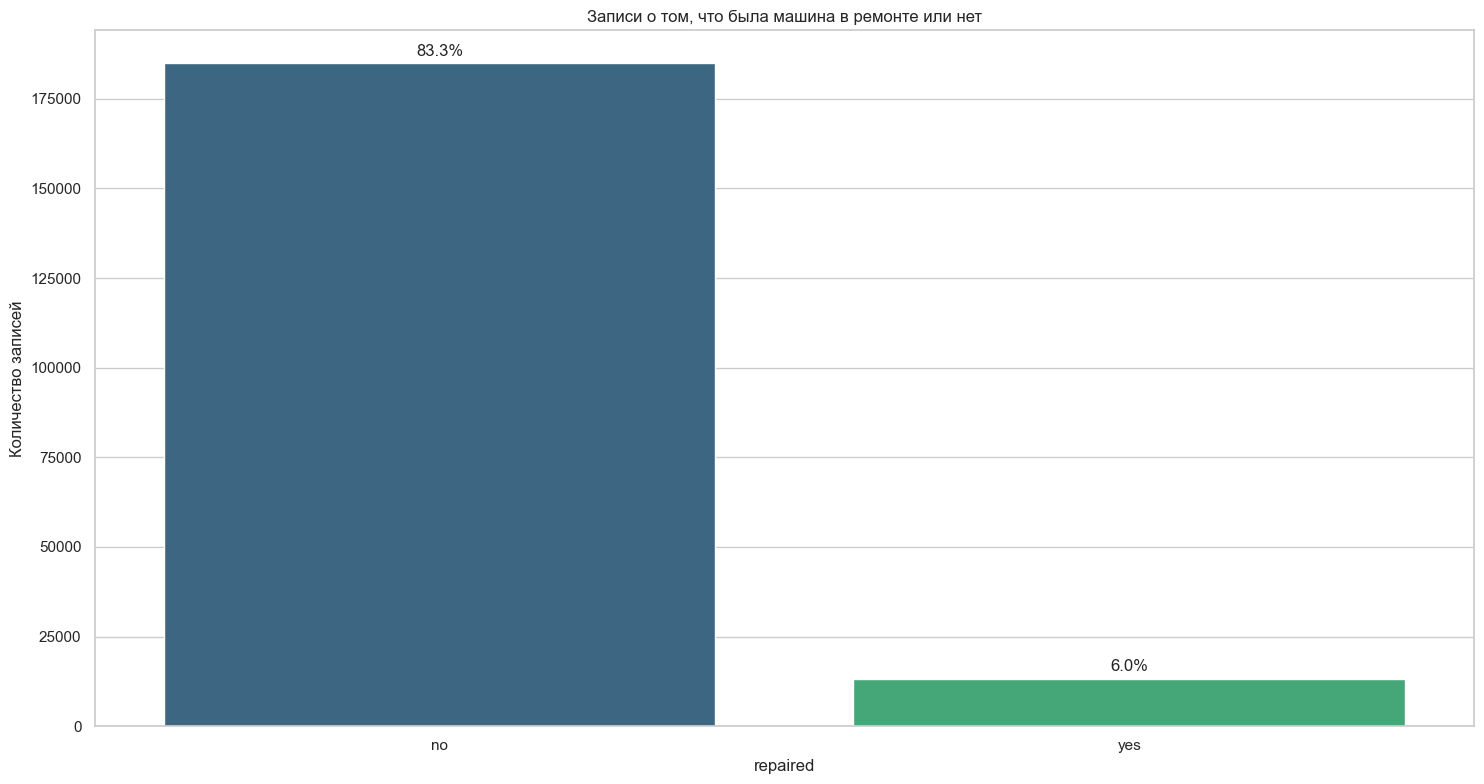

In [87]:
# визуализация признака 'repaired'
categorical(data_new_year, 'repaired', 'Записи о том, что была машина в ремонте или нет')

**Примечание:** В данных этого признака присутствуют пропущенные значения, которые необходимо заполнить. Однако заполнить его на наиболее часто встречающееся значение, в нашем случаем значением 'no', будет неправильно, так как мы можем отнести автомобили, которые подлежали ремонту в неправильную категорию. Данный признак будет важен для построения моделей, так как от него, в том числе, сильно зависит стоимость автомобиля. Поэтому, чтобы данные были более качественными, заменим все пропущенные значения на 'unknown'.

In [88]:
# замена пропущенных значений
data_new_year['repaired'] = data_new_year['repaired'].fillna(value='unknown')

In [89]:
# посмотрим пропуски в столбце после замены
data_new_year['repaired'].isna().sum()

0

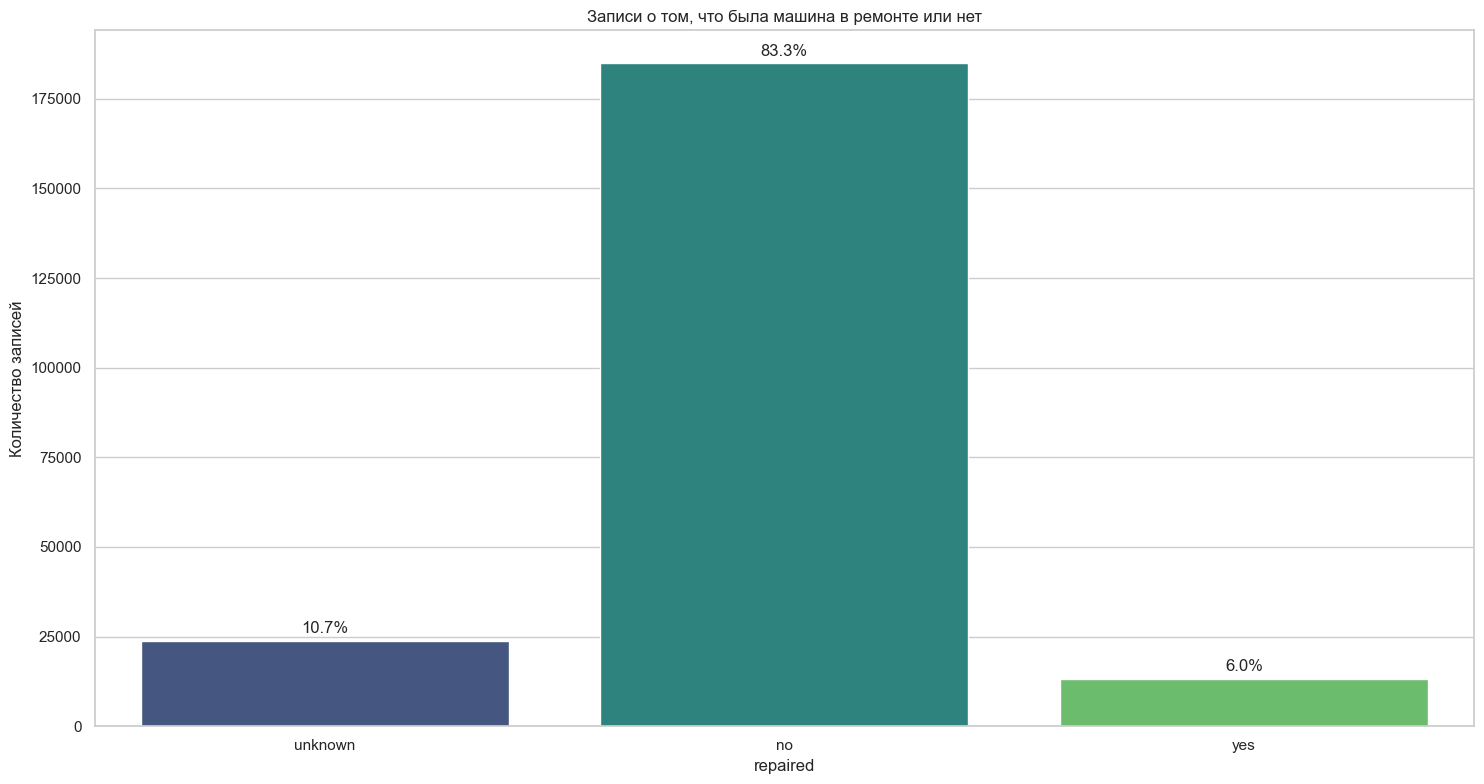

In [90]:
# снова визуализируем признак 'repaired'
categorical(data_new_year, 'repaired', 'Записи о том, что была машина в ремонте или нет')

**Примечание:** Пропуски в данных успешно обработаны.

### 2.13 Предобработка и исследовательский анализ данных в столбце 'date_created'

In [91]:
# посмотрим описательную статистику признака 'date_created'
data_new_year['date_created'].describe().to_frame()

,date_created
count,221910
mean,2016-03-20 20:38:47.127213568
min,2015-03-20 00:00:00
25%,2016-03-13 00:00:00
50%,2016-03-21 00:00:00
75%,2016-03-29 00:00:00
max,2016-04-07 00:00:00


In [92]:
# посмотрим количество пропусков в столбце 'date_created'
data_new_year['date_created'].isna().sum()

0

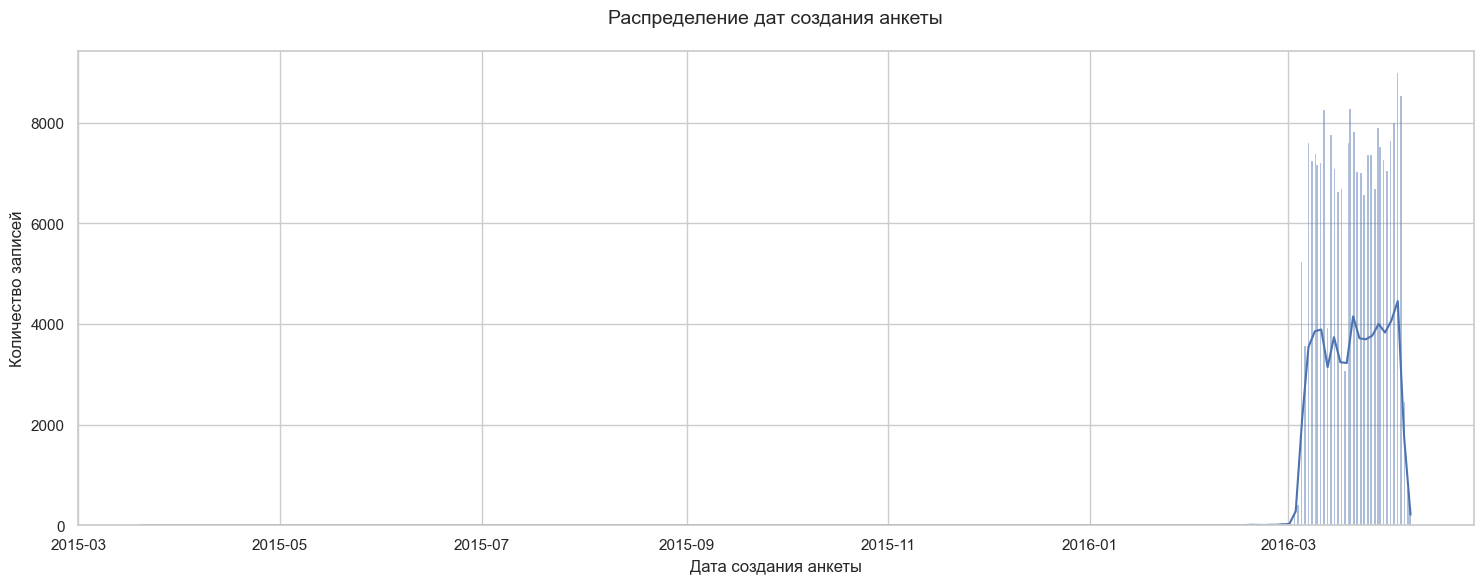

In [93]:
# для данного столбца построим только гистограмму, так как в нем присутствуют данные типа 'datetime'
# создание графика
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=data_new_year, x='date_created', kde=True)

# создание заголовков и подписей
ax.set_title(
    'Распределение дат создания анкеты',
    fontsize=14,
    pad=20)

ax.set_xlabel(
    'Дата создания анкеты',
    fontsize=12)

ax.set_ylabel(
    'Количество записей',
    fontsize=12)

# окончательная настройка графика
plt.tight_layout()
plt.show()

**Примечание:** По результатам построенного графика видно, что в основном даты составления анкеты сосредоточены в марте 2016 года. Скорее всего, этот признак не будет браться для построения моделей, так как будет не сильно значим для них.

### 2.14 Предобработка и исследовательский анализ данных в столбце 'number_of_pictures'

In [94]:
# посмотрим описательную статистику признака 'number_of_pictures'
data_new_year['number_of_pictures'].describe().to_frame()

,number_of_pictures
count,221910.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [95]:
# посмотрим количество пропусков в столбце 'number_of_pictures'
data_new_year['number_of_pictures'].isna().sum()

0

In [96]:
# посмотрим количество каждого уникального значения для этого столбца 
data_new_year['number_of_pictures'].value_counts().to_frame()

,count
number_of_pictures,
0,221910


**Примечание:** При проверке столбца 'number_of_pictures' на наличие пропусков было обнаружено, что для автомобилей, представленных на сервисе "Не бит, не крашен", вовсе отсутствуют фотографии машин. Визуализировать данный столбец не является целесообразным.

### 2.15 Предобработка и исследовательский анализ данных в столбце 'postal_code'

In [97]:
# посмотрим описательную статистику признака 'postal_code'
data_new_year['postal_code'].describe().to_frame()

,postal_code
count,221910.000000
mean,51890.941508
std,25717.085213
min,1067.000000
25%,31535.000000
50%,51105.000000
75%,72622.000000
max,99998.000000


In [98]:
# посмотрим количество пропусков в столбце 'postal_code'
data_new_year['postal_code'].isna().sum()

0

In [99]:
# посмотрим количество каждого уникального значения для этого столбца 
data_new_year['postal_code'].value_counts().to_frame()

,count
postal_code,
10115,786
65428,387
60311,251
66333,194
38518,192
...,...
98749,1
89183,1
95694,1


**Примечание:** В столбце данного признака присутствует 8101 запись, что очень сложно визуализировать на графике. В данном столбце отсутствуют пропуски, однако, кажется, что признак "Почтовый индекс владельца анкеты (пользователя)" будет мало информативен при построении моделей для расчета стоимости автомобилей.

### 2.16 Предобработка и исследовательский анализ данных в столбце 'last_seen'

In [100]:
# посмотрим описательную статистику признака 'last_seen'
data_new_year['last_seen'].describe().to_frame()

,last_seen
count,221910
mean,2016-03-30 15:41:08.814573568
min,2016-03-05 14:15:16
25%,2016-03-24 10:46:41
50%,2016-04-05 04:46:27.500000
75%,2016-04-06 12:17:44.750000128
max,2016-04-07 14:58:50


In [101]:
# посмотрим количество пропусков в столбце 'last_seen'
data_new_year['last_seen'].isna().sum()

0

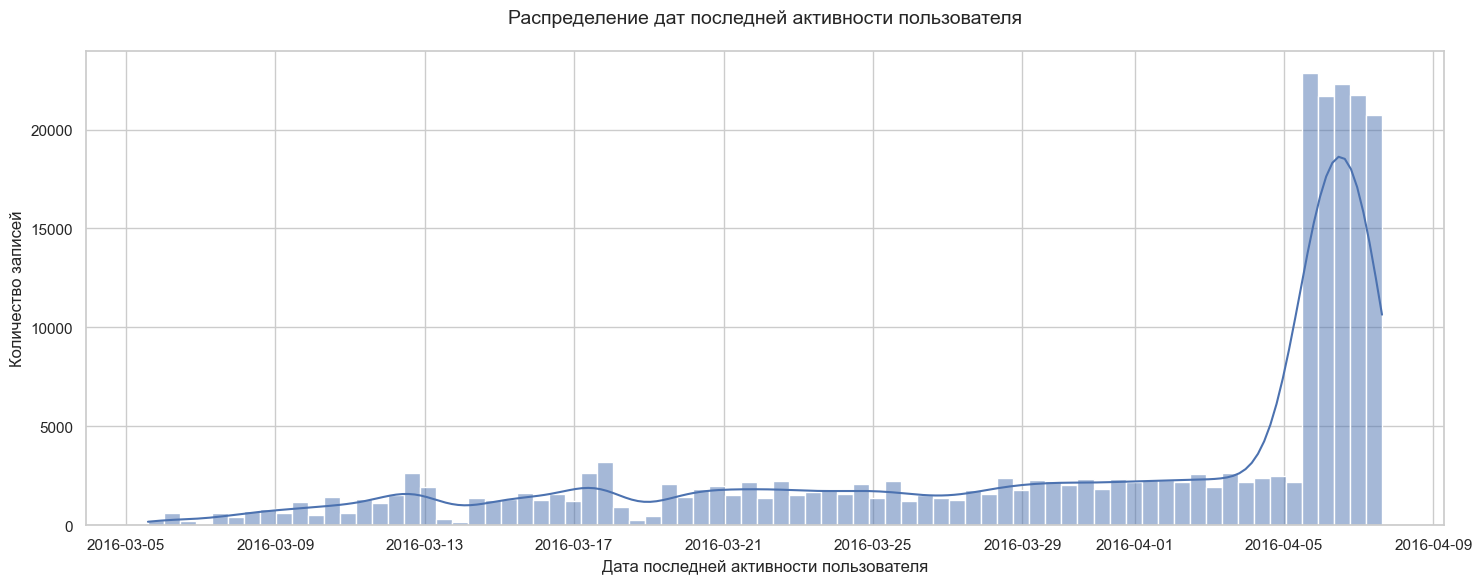

In [102]:
# для данного столбца построим только гистограмму, так как в нем присутствуют данные типа 'datetime'
# создание графика
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=data_new_year, x='last_seen', kde=True)

# создание заголовков и подписей
ax.set_title(
    'Распределение дат последней активности пользователя',
    fontsize=14,
    pad=20)

ax.set_xlabel(
    'Дата последней активности пользователя',
    fontsize=12)

ax.set_ylabel(
    'Количество записей',
    fontsize=12)

# окончательная настройка графика
plt.tight_layout()
plt.show()

**Примечание:** Данный признак вовсе не содержит пропусков, также по графику видно, что в основном даты последней активности пользователя сосредоточены в период с 5 по 7 апреля 2016 года.

### 2.17 Подготовка данных для обучения моделей

При проведении предобработки и исследовательского анализа данных были проанализированы столбцы со всеми признаками, что позволило сформировать датасет только с теми признаками, которые будут информативнф при построении моделей.

**Информативными признаками для моделей будут:** 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'fuel_type', 'brand', 'repaired'.

In [103]:
# соберем датасет со всеми необходимыми признаками
dataset = data_new_year[['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
                        'model', 'kilometer', 'fuel_type', 'brand', 'repaired']]

In [104]:
# посмотрим ощую информацию о получившемся датасете
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221910 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              221910 non-null  int64 
 1   vehicle_type       221910 non-null  object
 2   registration_year  221910 non-null  int64 
 3   gearbox            221910 non-null  object
 4   power              221910 non-null  int64 
 5   model              221910 non-null  object
 6   kilometer          221910 non-null  int64 
 7   fuel_type          221910 non-null  object
 8   brand              221910 non-null  object
 9   repaired           221910 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.6+ MB


In [105]:
# проверим датасет для обучения моделей на наличие явных дубликатов
dataset.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [106]:
# проверим получившийся датасет на наличие явных дубликатов
dataset.duplicated().sum()

30295

In [107]:
# удалим все появившиеся явные дубликаты, т.к. они не будут полезны при построении моделей
dataset = dataset.drop_duplicates()

# проверим датасет на наличие явных дубликатов после удаления уже выявленных
dataset.duplicated().sum()

0

**Примечание:** Полученный набор данных не содержит пропусков и явных дуюликатов.

In [108]:
# посмотрим первые 5 строк получившегося датасета
dataset.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown


In [109]:
# сбросим индексы после составления новго датасета
dataset = dataset.reset_index(drop=True)

# выведем первые 5 строк получившегося датасета
dataset.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
4,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown


**Обобщающий вывод этапа "Предобработка и исследовательский анализ данных":**
1. Названия всех столбцов в таблице приведены к общепринятому стилю.
2. В таблице удалено 4 явных дубликата.
3. Типы переменных в столбцах 'date_crawled', 'date_created', 'last_seen' приведены к формату 'datetime'.
4. Обработаны пропуски в столбцах: 'vehicle_type', 'gearbox', 'model', 'fuel_type' и 'repaired'.
5. Также обработы все обнаруженные аомалии в столбцах.
6. Был сформирован датасет со всеми информативными признаками, необходимыми для обучения моделей.

## 3. Подготовка выборок для обучения моделей

In [110]:
# разделим сформированный датасет на целевой признак и остальные
X = dataset.drop('price', axis=1)
y = dataset['price']

In [111]:
# выделяем тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

In [112]:
# выделяем валидационную выборку из тренировочной
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

In [113]:
# определяем признаки по их типу (категориальные и количественные)
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_features = [col for col in num_features if col != 'price']

In [114]:
# создаем пайплайн для реализации препроцессинга
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)

In [115]:
# реализуем преобразование
X_train_final_prepared = preprocessor.fit_transform(X_train_final)
X_valid_prepared = preprocessor.transform(X_valid)
X_test_prepared = preprocessor.transform(X_test)

In [116]:
# проверяем корректность разбиения на выборки
print('Размер тренировочной выборки - {:.0%}'.format(X_train_final.shape[0] / X.shape[0]))
print('Размер валидационной выборки - {:.0%}'.format(X_valid.shape[0] / X.shape[0]))
print('Размер тестовой выборки - {:.0%}'.format(X_test.shape[0] / X.shape[0]))

Размер тренировочной выборки - 64%
Размер валидационной выборки - 16%
Размер тестовой выборки - 20%


In [117]:
print(f"X_train_final_prepared shape: {X_train_final_prepared.shape}")
print(f"X_valid_prepared shape: {X_valid_prepared.shape}")
print(f"X_test_prepared shape: {X_test_prepared.shape}")

X_train_final_prepared shape: (122633, 308)
X_valid_prepared shape: (30659, 308)
X_test_prepared shape: (38323, 308)


**Обобщающий вывод этапа "Подготовка выборок для обучения моделей":**
1. Проведено кодирование категориальных признаков.
2. Проведено масштабирование количественных признаков перед обучением моделей.
3. Данные разбиты на тренировочную, валидационную и тестовую выборки, 64%, 16% и 20% соответственно.

## 4. Обучение и предсказание моделей

По условию задачи:
1. Для оценки качества моделей необходимо применять метрику RMSE.
2. Значение метрики RMSE должно быть **МЕНЬШЕ** 2500.

In [118]:
# напишем сосбтвенную функцию для обучения моделей, замера времени и подсчёта RMSE
def train_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = model.predict(X_valid)
    pred_time = time.time() - start_pred

    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    return rmse, train_time, pred_time

In [119]:
# создаем модели 
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    'CatBoostRegressor': CatBoostRegressor(random_state=RANDOM_STATE, verbose=100),
    'LightGBM': LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
}

In [120]:
# обучаем и сохраняем результаты
results = []

for name, model in models.items():
    rmse, train_time, pred_time = train_evaluate_model(
        model, X_train_final_prepared, y_train_final, X_valid_prepared, y_valid)
    results.append({
        'Model': name,
        'RMSE': rmse,
        'Train Time (s)': train_time,
        'Predict Time (s)': pred_time
    })

Learning rate set to 0.087535
0:	learn: 4363.9666856	total: 222ms	remaining: 3m 42s
100:	learn: 1830.8443082	total: 3.31s	remaining: 29.5s
200:	learn: 1733.0889819	total: 6.33s	remaining: 25.2s
300:	learn: 1683.8067006	total: 9.38s	remaining: 21.8s
400:	learn: 1652.3370306	total: 12.6s	remaining: 18.8s
500:	learn: 1629.1618282	total: 15.6s	remaining: 15.5s
600:	learn: 1610.6956835	total: 18.5s	remaining: 12.3s
700:	learn: 1595.7594847	total: 21.5s	remaining: 9.18s
800:	learn: 1582.8575346	total: 24.5s	remaining: 6.09s
900:	learn: 1571.5180812	total: 27.5s	remaining: 3.02s
999:	learn: 1561.6681633	total: 30.5s	remaining: 0us
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 122633, number of used features: 278
[LightGBM] [In

In [121]:
# выводим результаты в виде таблицы с сортировкой
results_df = pd.DataFrame(results).sort_values(by='RMSE')
results_df

,Model,RMSE,Train Time (s),Predict Time (s)
2,CatBoostRegressor,1620.064758,64.238024,7.986800
3,LightGBM,1689.155478,1.925644,0.215028
1,RandomForestRegressor,1708.545962,300.143235,1.075938
0,LinearRegression,2466.035015,5.719286,0.048481


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Валерия, аналогичные вопросы есть и к этой модели и к моделям ниже. Предложение: вначале доводим до идеала код в разделе "4.1  Модель: LinearRegression". После этого, по шаблону правим код в 3х моделях ниже. Принимается?
    
p.s. с 06.07 по 12.06 буду в командировке. Хотел бы проект принять до 06.07. Для ускорения отработки комментариев - мой ТГ: @aleks_nep. При необходимости можем созвониться и пообщаться голосом.    
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Хорошо, жду комментариев. Но т.к. полностью переделывала блоки 3-4 реализовала все модели другим способом. </font>
</div>

**Промежуточный вывод этапа "Обучение и предсказание моделей":**
1. Самой быстрой по сравнению с другими оказалась модель: LinearRegression. Однако результаты ее метрик оценки качества модели оказались самыми плохими.
2. По метрике оценки качества RMSE, которая по условию задачи должна быть меньше 2500, лучше всего себя снова показала модель: CatBoostRegressor.

## 5. Анализ времени обучения, времени предсказания и качества моделей. Выбор лучшей модели.

In [122]:
# повторный вывод результата
results_df

,Model,RMSE,Train Time (s),Predict Time (s)
2,CatBoostRegressor,1620.064758,64.238024,7.986800
3,LightGBM,1689.155478,1.925644,0.215028
1,RandomForestRegressor,1708.545962,300.143235,1.075938
0,LinearRegression,2466.035015,5.719286,0.048481


**Примечание:** Лучше моделью по метрике RMSE является CatBoostRegressor, однако, у нее достаточно долгое время обучения, поэтому стоит взять модель LightGBM, которая не сильно уступает по метрике качества, но значительно лучше показывает себя по скорости обучения и предсказания.

In [123]:
# выбираем лучшую модель
best_model = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1)
best_model.fit(X_train_final_prepared, y_train_final)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 122633, number of used features: 278
[LightGBM] [Info] Start training from score 6047.158147


LGBMRegressor(n_jobs=-1, random_state=42)

In [124]:
%%time
start_test_pred = time.time()
y_test_pred = best_model.predict(X_test_prepared)
test_pred_time = time.time() - start_test_pred

CPU times: total: 797 ms
Wall time: 254 ms


In [125]:
# расчет RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

# вывод итоговых результатов
print(f"RMSE на тесте: {rmse_test:.2f}")
print(f"Время предсказания: {test_pred_time:.4f} секунд")

RMSE на тесте: 1696.05
Время предсказания: 0.2537 секунд


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Только в этом разделе, после сравнения моделей по 3м критериям (из ТЗ) должна появиться тестовая выборка. Для самой лучшей модели. И всего один раз.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Исправлено. </font>
</div>

<div class="alert alert-warning">
<b>Комментарий 👉</b>



Как думаешь - почему "циферки" в эту ячейку вписывать - это не ОК?
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Там была таблица, заполненная руками (я ее убрала, т.к. она больше не нужна). Это не ОК, котому что полученные значения при обучении могут пометься, но новый данные в таблицу автоматически не подтянутся. </font>
</div>

**Обобщающий вывод этапа "Анализ времени обучения, времени предсказания и качества моделей. Выюор лучшей модели":**

По оценкам метрик качества модели наилучшей оказалась CatBoostRegressor **CatBoostRegressor**, её RMSE составил 1620.064758, но скорость обучения и предсказания достаточно страдает. Так как заказчику сервиса "Не бит, не крашен" важны все аспекты, а именно: время обучения, время предсказания и качество предсказания модели, наилучшей моделью я бы выбрала **LightGBM**, так как она является следующей по качеству пресказаний, но в то же время со значительно улучшенными показателями времени.

## 6. Итоговые выводы

В ходе работы были проанализированы данные, предоставленные сервисом по продаже автомобилей с пробегом «Не бит, не крашен», которая хочет разработать модель, позволяющую определить рыночную стоимость автомобиля.

Для реализации этой задачи было выполнено 5 этапов работы.

На **1 этапе: Загрузка и изучение данных** были проанализированы все исходные данные с входными признаками, дале на **2 этапе: Предобработка исследовательский анализ данных** данные были изучены более детально, а именно:
1. Названия всех столбцов в таблице приведены к общепринятому стилю.
2. В таблице удалено 4 явных дубликата.
3. Типы переменных в столбцах 'date_crawled', 'date_created', 'last_seen' приведены к формату 'datetime'.
4. Обработаны пропуски в столбцах: 'vehicle_type', 'gearbox', 'model', 'fuel_type' и 'repaired'.
5. Также обработы все обнаруженные аомалии в столбцах.
6. Был сформирован датасет со всеми информативными признаками, необходимыми для обучения моделей.

На **3 этапе: Подготовка выборок для обучения моделей** были получены следующие результаты:
1. Проведено кодирование категориальных признаков.
2. Проведено масштабирование количественных признаков перед обучением моделей.
3. Данные разбиты на тренировочную, валидационную и тестовую выборки, 64%, 16% и 20% соответственно.

На **4 этапе: Обучение и предсказание моделей** было рассчитано, что:
1. Самой быстрой по сравнению с другими оказалась модель: LinearRegression. Однако результаты ее метрик оценки качества модели оказались самыми плохими.
2. По метрике оценки качества RMSE, которая по условию задачи должна быть меньше 2500, лучше всего себя снова показала модель: CatBoostRegressor.

На **5 этапе: Анализ времени обучения, времени предсказания и качества моделей. выбор лучшей модели** были сделаны выводы о том, что:
По оценкам метрик качества модели наилучшей оказалась CatBoostRegressor **CatBoostRegressor**, её RMSE составил 1620.064758, но скорость обучения и предсказания достаточно страдает. Так как заказчику сервиса "Не бит, не крашен" важны все аспекты, а именно: время обучения, время предсказания и качество предсказания модели, наилучшей моделью я бы выбрала **LightGBM**, так как она является следующей по качеству пресказаний, но в то же время со значительно улучшенными показателями времени.

**Таким образом,** анализируя всю полученную в ходе исследования информацию, можно сделать вывод, что наилучшей моделью для предсказания рыночной стоимости автомобиля является LightGBM, так как заказчику важны все аспекты работы модели, а именно: время обучения, время предсказания и качество предсказаний.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

# Результат ревью:

Я отмечаю адекватный уровень твоей программистской подготовки. Ты используешь продвинутые концепции языка Python, библиотеки pandas и одной из основных библиотек машинного обучения sckit-learn. Всё это в целом упрощает твой код и одновременно показывает твой уровень владения инструментами анализа данных и machine learning.

С комментированием никаких проблем нет. Твоих объяснений достаточно для понимания твоими коллегами хода мыслей. Ссылки из брифа проекта в нужных местах также помогают следовать за развитием событий и дают полную информацию касаемо того, что будет происходить в том или ином разделе проекта.

Мне было просто проверять твой проект, потому что он чётко структурирован, с использованием оглавления. 

Зелёным цветом я отметил и прокомментировал удачные и элегантные решения, на которые ты можешь опираться в будущих проектах.

Жёлтым цветом я выделил то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас.

Однако есть принципиальные моменты, которые не позволяют мне принять твой проект в его нынешнем состоянии:

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b> 

1. (19) Вопрос к "низким" ценам автомобилей.    

2. (19) Из каких соображений ты отсекаешь данные по ценам авто "сверху"?
    
3. (50) Вопрос к мощностям автомобилей.    
    
4. (95) Дубликаты надо проверить ещё раз, уже после удаления неинформативных признаков.    
    
5. (100) Кодировать данные следует ПОСЛЕ разбиения данных на выборки. Если кодирование (и/или масштабирование) выполняются до разбиения данных на выборки, то информация из тестовой выборки может просочиться в обучающую выборку. Это может привести к переобучению модели и неверным результатам.    
    
6. (108) OrdinalEncoder - это плохой выбор для кодирования категорий, между которыми нет порядковых отношений и/или отношений "меньше-больше", в случае использования данных в линейных моделях.

7. (108) Почему разбиваешь данные только на 2 выборки (и при этом не используешь кросс-валидацию)?    
    
8. (110) Неверный расчет времени предсказания моделей (в зависимости от выбранного тобой метода подбора гиперпараметров).    
    
9. (113) У тебя серъёзная методическая ошибка. Ответь на вопрос: какая модель по результатам валидации/кросс-валидации должна проверяться на тестовой выборке?    
</div>

Эти моменты требуют твоего внимания. Комментарии по ним помечены красным цветом. 

Подводя итог: хорошая работа на самом-то деле, молодец! Есть несколько моментов к исправлению, но уверен, что они не вызовут у тебя сложностей. После доработки обязательно проверь комментарии и выводы. Их нужно будет скорректировать. Жду доработанную версию проекта на повторное ревью.

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Все комментарии от ревьюера перенесла и, вроде, на все ответила. итоговый вывод подкорректировала. </font>
</div>